### Import Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

In [30]:
# Load historical funding rate data
df = pd.read_csv("dataset/binance_btc_usdt_1_year_data_8h.csv")

In [6]:
df.head

<bound method NDFrame.head of                timestamp  close_spot  close_futures  funding_rate
0    2024-02-12 16:00:00    49917.27        49943.6      0.000100
1    2024-02-13 00:00:00    49983.09        50019.9      0.000100
2    2024-02-13 08:00:00    48727.47        48753.1      0.000100
3    2024-02-13 16:00:00    49699.59        49696.4      0.000100
4    2024-02-14 00:00:00    49838.93        49845.0      0.000100
..                   ...         ...            ...           ...
995  2025-01-09 08:00:00    94244.02        94195.2      0.000100
996  2025-01-09 16:00:00    92552.49        92505.9      0.000098
997  2025-01-10 00:00:00    94492.63        94457.0     -0.000005
998  2025-01-10 08:00:00    93730.92        93704.0      0.000040
999  2025-01-10 16:00:00    94726.11        94675.5     -0.000011

[1000 rows x 4 columns]>

### Parameters

In [ ]:
# # Parameters
# min_funding_rate = 0.0001  # Minimum funding rate to consider arbitrage
# max_funding_rate = 0.01    # Maximum funding rate to prevent outlier trades
# trade_size = 0.01          # Base BTC per trade
# max_trade_size = 0.05      # Maximum position size
# max_open_positions = 3     # Maximum number of simultaneous open positions
# max_drawdown_pct = 0.05    # Maximum allowed drawdown (5%)
# stop_loss_pct = 0.02       # Stop loss percentage (2%)

# # RSI Parameters
# rsi_period = 14            # Period for RSI calculation
# rsi_oversold = 30          # Oversold threshold
# rsi_overbought = 70        # Overbought threshold

# # Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
# risk_free_rate = 0.02      # 2% annual risk-free rate

# # Risk management variables
# account_balance = 10000    # Starting account balance in USD
# open_positions = []        # Track open positions
# total_profit = 0           # Track total profit
# max_balance = account_balance  # Track maximum balance for drawdown calculation
# daily_returns = []         # List to store daily returns for Sharpe ratio calculation


### Functions
- calculate_rsi: Calculates the Relative Strength Index technical indicator
- calculate_sharpe_ratio: Evaluates risk-adjusted performance
- check_arbitrage_opportunity: Identifies potential arbitrage opportunities
- calculate_position_size: Sizes positions based on funding rate magnitude
- open_hedge_position: Executes the opening of hedge positions in spot and futures markets
- close_positions: Closes existing positions
- calculate_total_profit: Calculates the total profit from an arbitrage position
- check_stop_loss: Determines if a stop loss has been triggered
- funding_arbitrage_bot: The main function that runs the entire strategy backtest

In [ ]:
# # Function to calculate RSI
# def calculate_rsi(data, period=14):
#     # Calculate price changes
#     delta = data.diff()
    
#     # Separate gains and losses
#     gain = delta.where(delta > 0, 0)
#     loss = -delta.where(delta < 0, 0)
    
#     # Calculate average gain and loss
#     avg_gain = gain.rolling(window=period).mean()
#     avg_loss = loss.rolling(window=period).mean()
    
#     # Calculate relative strength
#     rs = avg_gain / avg_loss
    
#     # Calculate RSI
#     rsi = 100 - (100 / (1 + rs))
    
#     return rsi

# # Function to calculate Sharpe ratio
# def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
#     """
#     Calculate the annualized Sharpe ratio.
    
#     Parameters:
#     - returns: List of daily returns
#     - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
#     - trading_days: Number of trading days in a year
    
#     Returns:
#     - Sharpe ratio
#     """
#     if not returns or len(returns) < 2:
#         return 0
    
#     # Convert annual risk-free rate to daily
#     daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
#     # Calculate excess returns
#     excess_returns = [r - daily_risk_free for r in returns]
    
#     # Calculate mean and standard deviation of excess returns
#     mean_excess_return = np.mean(excess_returns)
#     std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
#     if std_excess_return == 0:
#         return 0
    
#     # Daily Sharpe ratio
#     daily_sharpe = mean_excess_return / std_excess_return
    
#     # Annualized Sharpe ratio
#     annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
#     return annualized_sharpe

# # Function to round trade size to 5 decimal places
# def round_trade_size(size):
#     return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# # Function to check if arbitrage opportunity exists
# def check_arbitrage_opportunity(df, min_funding_rate, max_funding_rate):
#     # Filter out opportunities that are too small or suspiciously large
#     return df[(abs(df['funding_rate']) >= min_funding_rate) & 
#             (abs(df['funding_rate']) <= max_funding_rate)]

# # Function to size position based on funding rate magnitude
# def calculate_position_size(funding_rate, trade_size, max_trade_size):
#     # Scale position size based on funding rate magnitude (larger funding = larger position)
#     # But never exceed max_trade_size
#     scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
#     # Round to 5 decimal places
#     return round_trade_size(min(scaled_size, max_trade_size))

# # Function to determine hedge positions
# def open_hedge_position(trade_size, funding_rate, mark_price):
#     if funding_rate > 0: 
#         side_spot = 'buy'
#         side_futures = 'sell'
#     else:
#         side_spot = 'sell'
#         side_futures = 'buy'
    
#     position_value = trade_size * mark_price
#     print(f"Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
#     return side_spot, side_futures

# # Function to close positions
# def close_positions(trade_size, funding_rate, mark_price):
#     if funding_rate > 0:
#         side_spot = 'sell'
#         side_futures = 'buy'
#     else:
#         side_spot = 'buy'
#         side_futures = 'sell'
    
#     position_value = trade_size * mark_price
#     print(f"Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
#     return side_spot, side_futures

# # Function to calculate total profit
# def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures):
#     """
#     Calculates total funding arbitrage profit:
#     - Funding fee profit
#     - Spot position profit/loss
#     - Futures position profit/loss
#     """
#     # Funding Profit (8-hour funding period)
#     funding_profit = trade_size * funding_rate * mark_price

#     # Determine trade direction based on funding rate
#     if funding_rate > 0:
#         spot_side_multiplier = 1     # Buying spot (long)
#         futures_side_multiplier = -1  # Shorting futures
#     else:
#         spot_side_multiplier = -1     # Selling spot (short)
#         futures_side_multiplier = 1   # Longing futures

#     # Spot Profit/Loss
#     spot_pnl = trade_size * (close_spot - entry_spot) * spot_side_multiplier

#     # Futures Profit/Loss
#     futures_pnl = trade_size * (entry_futures - close_futures) * futures_side_multiplier

#     # Total Profit
#     total_profit = funding_profit + spot_pnl + futures_pnl

#     return total_profit, funding_profit, spot_pnl, futures_pnl

# # Check if stop loss is triggered
# def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
#     funding_rate = position['funding_rate']
#     entry_spot = position['entry_spot']
#     entry_futures = position['entry_futures']
#     trade_size = position['trade_size']
    
#     # Calculate current PnL (excluding funding, which is already locked in)
#     if funding_rate > 0:  # Long spot, short futures
#         spot_pnl = trade_size * (current_spot - entry_spot)
#         futures_pnl = trade_size * (entry_futures - current_futures)
#     else:  # Short spot, long futures
#         spot_pnl = trade_size * (entry_spot - current_spot)
#         futures_pnl = trade_size * (current_futures - entry_futures)
    
#     current_pnl = spot_pnl + futures_pnl
#     position_value = trade_size * entry_spot
    
#     # Check if loss exceeds stop loss threshold
#     if current_pnl < -position_value * stop_loss_pct:
#         return True
#     return False

# # Function to run the funding arbitrage bot with risk management and RSI
# def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct, rsi_period, rsi_oversold, rsi_overbought, risk_free_rate):
#     global account_balance, open_positions, total_profit, max_balance, daily_returns
    
#     results = []
#     position_id = 0
    
#     # Calculate RSI for both spot and futures prices
#     df['spot_rsi'] = calculate_rsi(df['close_spot'], rsi_period)
#     df['futures_rsi'] = calculate_rsi(df['close_futures'], rsi_period)
    
#     # Add date column for grouping returns by day
#     df['date'] = pd.to_datetime(df['timestamp']).dt.date
    
#     # Create a daily balance tracker for Sharpe ratio calculation
#     daily_balance = {}
#     prev_balance = account_balance
#     current_date = None
    
#     # Filter for arbitrage opportunities
#     arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate, max_funding_rate)

#     for index, row in df.iterrows():
#         # Skip first RSI_PERIOD rows as RSI is not calculated yet
#         if index < rsi_period:
#             continue
            
#         timestamp = row['timestamp']
#         current_date = row['date']
#         current_spot = row['close_spot']
#         current_futures = row['close_futures']
#         spot_rsi = row['spot_rsi']
#         futures_rsi = row['futures_rsi']
        
#         # 1. Check existing positions for stop loss or closing
#         positions_to_close = []
#         for pos in open_positions:
#             # Check if stop loss is triggered
#             if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
#                 print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
#                 positions_to_close.append(pos)
            
#             # Check if position has reached its target close time
#             elif index >= pos['target_close_index']:
#                 print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
#                 positions_to_close.append(pos)
            
#             # Check if RSI signals position exit
#             elif (pos['funding_rate'] > 0 and spot_rsi > rsi_overbought) or (pos['funding_rate'] < 0 and spot_rsi < rsi_oversold):
#                 print(f"\n[Position {pos['id']}] ⚠️ RSI exit signal! Spot RSI: {spot_rsi:.2f}. Closing position.")
#                 positions_to_close.append(pos)
        
#         # Close positions that need closing
#         for pos in positions_to_close:
#             close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
            
#             # Calculate final profit
#             profit, funding_profit, spot_pnl, futures_pnl = calculate_total_profit(
#                 pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#             )
            
#             # Update account balance
#             account_balance += profit
#             total_profit += profit
#             max_balance = max(max_balance, account_balance)
            
#             # Log results
#             results.append([
#                 timestamp, pos['funding_rate'], pos['trade_size'], 
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#                 profit, funding_profit, spot_pnl, futures_pnl, 
#                 pos['entry_spot_rsi'], spot_rsi, pos['entry_futures_rsi'], futures_rsi
#             ])
            
#             print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f})")
#             print(f"RSI at entry - Spot: {pos['entry_spot_rsi']:.2f}, Futures: {pos['entry_futures_rsi']:.2f}")
#             print(f"RSI at exit - Spot: {spot_rsi:.2f}, Futures: {futures_rsi:.2f}")
#             open_positions.remove(pos)
        
#         # 2. Check drawdown - pause trading if exceeded
#         current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
#         if current_drawdown > max_drawdown_pct:
#             print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
#             continue
        
#         # 3. Check for new arbitrage opportunity
#         funding_rate = row['funding_rate']
#         if abs(funding_rate) >= min_funding_rate and abs(funding_rate) <= max_funding_rate:
            
#             # Check if we can open new positions
#             if len(open_positions) < max_open_positions:
#                 mark_price = row['close_futures']  # Mark price is usually close to futures price
#                 entry_spot = row['close_spot']
#                 entry_futures = row['close_futures']
                
#                 # Size position based on funding rate magnitude
#                 adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
#                 # Calculate capital needed
#                 position_value = adjusted_size * mark_price
                
#                 # RSI filter logic for entry
#                 rsi_entry_condition = False
                
#                 if funding_rate > 0:  # We'll go long spot, short futures
#                     # For long spot: Enter when spot is oversold (low RSI)
#                     # For short futures: Enter when futures is overbought (high RSI)
#                     rsi_entry_condition = (spot_rsi < rsi_oversold or futures_rsi > rsi_overbought)
#                 else:  # We'll short spot, long futures
#                     # For short spot: Enter when spot is overbought (high RSI)
#                     # For long futures: Enter when futures is oversold (low RSI)
#                     rsi_entry_condition = (spot_rsi > rsi_overbought or futures_rsi < rsi_oversold)
                
#                 # Check if we have enough capital (using 50% of available balance per trade) and RSI condition is met
#                 if position_value <= account_balance * 0.5 and rsi_entry_condition:
#                     print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
#                     print(f"RSI - Spot: {spot_rsi:.2f}, Futures: {futures_rsi:.2f}")
                    
#                     # Open hedge positions
#                     side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
#                     # Target closing at next funding time (8 hours later) or 3 data points if using hourly data
#                     target_close_index = index + 3
                    
#                     # Record position
#                     position = {
#                         'id': position_id,
#                         'timestamp': timestamp,
#                         'funding_rate': funding_rate,
#                         'trade_size': adjusted_size,
#                         'entry_spot': entry_spot,
#                         'entry_futures': entry_futures,
#                         'mark_price': mark_price,
#                         'open_index': index,
#                         'target_close_index': target_close_index,
#                         'entry_spot_rsi': spot_rsi,
#                         'entry_futures_rsi': futures_rsi
#                     }
#                     open_positions.append(position)
#                     position_id += 1
#                 elif not rsi_entry_condition:
#                     print(f"RSI conditions not met for entry. Spot RSI: {spot_rsi:.2f}, Futures RSI: {futures_rsi:.2f}")
#                 else:
#                     print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
#         # Track daily balance for returns calculation
#         if current_date not in daily_balance:
#             # If this is a new day, calculate return from previous day
#             if prev_balance > 0 and len(daily_balance) > 0:
#                 # Calculate daily return
#                 daily_return = (account_balance / prev_balance) - 1
#                 daily_returns.append(daily_return)
                
#             # Store today's balance
#             daily_balance[current_date] = account_balance
#             prev_balance = account_balance
    
#     # Close any remaining open positions at the end of the backtest
#     for pos in open_positions:
#         current_spot = df.iloc[-1]['close_spot']
#         current_futures = df.iloc[-1]['close_futures']
#         spot_rsi = df.iloc[-1]['spot_rsi']
#         futures_rsi = df.iloc[-1]['futures_rsi']
        
#         close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
        
#         # Calculate final profit
#         profit, funding_profit, spot_pnl, futures_pnl = calculate_total_profit(
#             pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#         )
        
#         # Update account balance
#         account_balance += profit
#         total_profit += profit
        
#         # Log results
#         results.append([
#             df.iloc[-1]['timestamp'], pos['funding_rate'], pos['trade_size'], 
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#             profit, funding_profit, spot_pnl, futures_pnl,
#             pos['entry_spot_rsi'], spot_rsi, pos['entry_futures_rsi'], futures_rsi
#         ])

#     # Final balance for the last day
#     if current_date and prev_balance > 0:
#         daily_return = (account_balance / prev_balance) - 1
#         daily_returns.append(daily_return)

#     # Calculate Sharpe ratio
#     # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
#     trading_periods_per_year = (24/8) * 365  # For 8-hour data
#     sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

#     # Save results to CSV
#     results_df = pd.DataFrame(results, columns=[
#         'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
#         'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
#         'spot_pnl', 'futures_pnl', 'entry_spot_rsi', 'exit_spot_rsi', 
#         'entry_futures_rsi', 'exit_futures_rsi'
#     ])
#     results_df.to_csv("dataset/funding_arbitrage_results_2.csv", index=False)
    
#     # Save daily returns for further analysis
#     daily_returns_df = pd.DataFrame({
#         'date': list(daily_balance.keys()),
#         'balance': list(daily_balance.values())
#     })
#     daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
#     daily_returns_df.to_csv("dataset/daily_returns.csv", index=False)
    
#     # Calculate additional performance metrics
#     total_trades = len(results_df)
#     profitable_trades = len(results_df[results_df['total_profit'] > 0])
#     win_rate = profitable_trades / total_trades if total_trades > 0 else 0
#     avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    
#     # Calculate volatility (standard deviation of returns)
#     volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
#     # Calculate max drawdown
#     cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
#     running_max = np.maximum.accumulate(cumulative_returns)
#     drawdowns = (cumulative_returns / running_max) - 1
#     max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
#     # Calculate annualized return
#     if len(daily_returns) > 0:
#         cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
#     else:
#         cagr = 0
    
#     print("\n=== PERFORMANCE SUMMARY ===")
#     print(f"Starting Balance: ${10000:.2f}")
#     print(f"Final Balance: ${account_balance:.2f}")
#     print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
#     print(f"Trading Days: {len(daily_balance)}")
#     print(f"Annualized Return: {cagr:.2%}")
#     print(f"Annualized Volatility: {volatility:.2%}")
#     print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
#     print(f"Max Drawdown: {max_dd:.2%}")
#     print(f"Total Trades: {total_trades}")
#     print(f"Win Rate: {win_rate:.2%}")
#     print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
#     # RSI effectiveness statistics
#     if total_trades > 0:
#         avg_entry_spot_rsi = results_df['entry_spot_rsi'].mean()
#         avg_exit_spot_rsi = results_df['exit_spot_rsi'].mean()
#         print(f"\n=== RSI STATISTICS ===")
#         print(f"Average Entry Spot RSI: {avg_entry_spot_rsi:.2f}")
#         print(f"Average Exit Spot RSI: {avg_exit_spot_rsi:.2f}")
        
#         # Analyze performance by RSI ranges
#         results_df['rsi_range'] = pd.cut(results_df['entry_spot_rsi'], 
#                                         bins=[0, 30, 70, 100], 
#                                         labels=['Oversold', 'Neutral', 'Overbought'])
#         rsi_performance = results_df.groupby('rsi_range')['total_profit'].agg(['mean', 'count'])
#         print("\nPerformance by Entry RSI Range:")
#         print(rsi_performance)
    
#     print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_2.csv'.")
#     return sharpe_ratio, cagr, volatility, max_dd

### Main Function

In [ ]:
# # Function to run the funding arbitrage bot with risk management and RSI
# def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct, rsi_period, rsi_oversold, rsi_overbought, risk_free_rate):
#     global account_balance, open_positions, total_profit, max_balance, daily_returns
    
#     results = []
#     position_id = 0
    
#     # Calculate RSI for both spot and futures prices
#     df['spot_rsi'] = calculate_rsi(df['close_spot'], rsi_period)
#     df['futures_rsi'] = calculate_rsi(df['close_futures'], rsi_period)
    
#     # Add date column for grouping returns by day
#     df['date'] = pd.to_datetime(df['timestamp']).dt.date
    
#     # Create a daily balance tracker for Sharpe ratio calculation
#     daily_balance = {}
#     prev_balance = account_balance
#     current_date = None
    
#     # Filter for arbitrage opportunities
#     arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate, max_funding_rate)

#     for index, row in df.iterrows():
#         # Skip first RSI_PERIOD rows as RSI is not calculated yet
#         if index < rsi_period:
#             continue
            
#         timestamp = row['timestamp']
#         current_date = row['date']
#         current_spot = row['close_spot']
#         current_futures = row['close_futures']
#         spot_rsi = row['spot_rsi']
#         futures_rsi = row['futures_rsi']
        
#         # 1. Check existing positions for stop loss or closing
#         positions_to_close = []
#         for pos in open_positions:
#             # Check if stop loss is triggered
#             if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
#                 print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
#                 positions_to_close.append(pos)
            
#             # Check if position has reached its target close time
#             elif index >= pos['target_close_index']:
#                 print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
#                 positions_to_close.append(pos)
            
#             # Check if RSI signals position exit
#             elif (pos['funding_rate'] > 0 and spot_rsi > rsi_overbought) or (pos['funding_rate'] < 0 and spot_rsi < rsi_oversold):
#                 print(f"\n[Position {pos['id']}] ⚠️ RSI exit signal! Spot RSI: {spot_rsi:.2f}. Closing position.")
#                 positions_to_close.append(pos)
        
#         # Close positions that need closing
#         for pos in positions_to_close:
#             close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
            
#             # Calculate final profit
#             profit, funding_profit, spot_pnl, futures_pnl = calculate_total_profit(
#                 pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#             )
            
#             # Update account balance
#             account_balance += profit
#             total_profit += profit
#             max_balance = max(max_balance, account_balance)
            
#             # Log results
#             results.append([
#                 timestamp, pos['funding_rate'], pos['trade_size'], 
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#                 profit, funding_profit, spot_pnl, futures_pnl, 
#                 pos['entry_spot_rsi'], spot_rsi, pos['entry_futures_rsi'], futures_rsi
#             ])
            
#             print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f})")
#             print(f"RSI at entry - Spot: {pos['entry_spot_rsi']:.2f}, Futures: {pos['entry_futures_rsi']:.2f}")
#             print(f"RSI at exit - Spot: {spot_rsi:.2f}, Futures: {futures_rsi:.2f}")
#             open_positions.remove(pos)
        
#         # 2. Check drawdown - pause trading if exceeded
#         current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
#         if current_drawdown > max_drawdown_pct:
#             print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
#             continue
        
#         # 3. Check for new arbitrage opportunity
#         funding_rate = row['funding_rate']
#         if abs(funding_rate) >= min_funding_rate and abs(funding_rate) <= max_funding_rate:
            
#             # Check if we can open new positions
#             if len(open_positions) < max_open_positions:
#                 mark_price = row['close_futures']  # Mark price is usually close to futures price
#                 entry_spot = row['close_spot']
#                 entry_futures = row['close_futures']
                
#                 # Size position based on funding rate magnitude
#                 adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
#                 # Calculate capital needed
#                 position_value = adjusted_size * mark_price
                
#                 # RSI filter logic for entry
#                 rsi_entry_condition = False
                
#                 if funding_rate > 0:  # We'll go long spot, short futures
#                     # For long spot: Enter when spot is oversold (low RSI)
#                     # For short futures: Enter when futures is overbought (high RSI)
#                     rsi_entry_condition = (spot_rsi < rsi_oversold or futures_rsi > rsi_overbought)
#                 else:  # We'll short spot, long futures
#                     # For short spot: Enter when spot is overbought (high RSI)
#                     # For long futures: Enter when futures is oversold (low RSI)
#                     rsi_entry_condition = (spot_rsi > rsi_overbought or futures_rsi < rsi_oversold)
                
#                 # Check if we have enough capital (using 50% of available balance per trade) and RSI condition is met
#                 if position_value <= account_balance * 0.5 and rsi_entry_condition:
#                     print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
#                     print(f"RSI - Spot: {spot_rsi:.2f}, Futures: {futures_rsi:.2f}")
                    
#                     # Open hedge positions
#                     side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
#                     # Target closing at next funding time (8 hours later) or 3 data points if using hourly data
#                     target_close_index = index + 3
                    
#                     # Record position
#                     position = {
#                         'id': position_id,
#                         'timestamp': timestamp,
#                         'funding_rate': funding_rate,
#                         'trade_size': adjusted_size,
#                         'entry_spot': entry_spot,
#                         'entry_futures': entry_futures,
#                         'mark_price': mark_price,
#                         'open_index': index,
#                         'target_close_index': target_close_index,
#                         'entry_spot_rsi': spot_rsi,
#                         'entry_futures_rsi': futures_rsi
#                     }
#                     open_positions.append(position)
#                     position_id += 1
#                 elif not rsi_entry_condition:
#                     print(f"RSI conditions not met for entry. Spot RSI: {spot_rsi:.2f}, Futures RSI: {futures_rsi:.2f}")
#                 else:
#                     print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
#         # Track daily balance for returns calculation
#         if current_date not in daily_balance:
#             # If this is a new day, calculate return from previous day
#             if prev_balance > 0 and len(daily_balance) > 0:
#                 # Calculate daily return
#                 daily_return = (account_balance / prev_balance) - 1
#                 daily_returns.append(daily_return)
                
#             # Store today's balance
#             daily_balance[current_date] = account_balance
#             prev_balance = account_balance
    
#     # Close any remaining open positions at the end of the backtest
#     for pos in open_positions:
#         current_spot = df.iloc[-1]['close_spot']
#         current_futures = df.iloc[-1]['close_futures']
#         spot_rsi = df.iloc[-1]['spot_rsi']
#         futures_rsi = df.iloc[-1]['futures_rsi']
        
#         close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
        
#         # Calculate final profit
#         profit, funding_profit, spot_pnl, futures_pnl = calculate_total_profit(
#             pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#         )
        
#         # Update account balance
#         account_balance += profit
#         total_profit += profit
        
#         # Log results
#         results.append([
#             df.iloc[-1]['timestamp'], pos['funding_rate'], pos['trade_size'], 
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#             profit, funding_profit, spot_pnl, futures_pnl,
#             pos['entry_spot_rsi'], spot_rsi, pos['entry_futures_rsi'], futures_rsi
#         ])

#     # Final balance for the last day
#     if current_date and prev_balance > 0:
#         daily_return = (account_balance / prev_balance) - 1
#         daily_returns.append(daily_return)

#     # Calculate Sharpe ratio
#     # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
#     trading_periods_per_year = (24/8) * 365  # For 8-hour data
#     sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

#     # Save results to CSV
#     results_df = pd.DataFrame(results, columns=[
#         'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
#         'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
#         'spot_pnl', 'futures_pnl', 'entry_spot_rsi', 'exit_spot_rsi', 
#         'entry_futures_rsi', 'exit_futures_rsi'
#     ])
#     results_df.to_csv("dataset/funding_arbitrage_results_2.csv", index=False)
    
#     # Save daily returns for further analysis
#     daily_returns_df = pd.DataFrame({
#         'date': list(daily_balance.keys()),
#         'balance': list(daily_balance.values())
#     })
#     daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
#     daily_returns_df.to_csv("dataset/daily_returns.csv", index=False)
    
#     # Calculate additional performance metrics
#     total_trades = len(results_df)
#     profitable_trades = len(results_df[results_df['total_profit'] > 0])
#     win_rate = profitable_trades / total_trades if total_trades > 0 else 0
#     avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    
#     # Calculate volatility (standard deviation of returns)
#     volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
#     # Calculate max drawdown
#     cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
#     running_max = np.maximum.accumulate(cumulative_returns)
#     drawdowns = (cumulative_returns / running_max) - 1
#     max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
#     # Calculate annualized return
#     if len(daily_returns) > 0:
#         cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
#     else:
#         cagr = 0
    
#     print("\n=== PERFORMANCE SUMMARY ===")
#     print(f"Starting Balance: ${10000:.2f}")
#     print(f"Final Balance: ${account_balance:.2f}")
#     print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
#     print(f"Trading Days: {len(daily_balance)}")
#     print(f"Annualized Return: {cagr:.2%}")
#     print(f"Annualized Volatility: {volatility:.2%}")
#     print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
#     print(f"Max Drawdown: {max_dd:.2%}")
#     print(f"Total Trades: {total_trades}")
#     print(f"Win Rate: {win_rate:.2%}")
#     print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
#     # RSI effectiveness statistics
#     if total_trades > 0:
#         avg_entry_spot_rsi = results_df['entry_spot_rsi'].mean()
#         avg_exit_spot_rsi = results_df['exit_spot_rsi'].mean()
#         print(f"\n=== RSI STATISTICS ===")
#         print(f"Average Entry Spot RSI: {avg_entry_spot_rsi:.2f}")
#         print(f"Average Exit Spot RSI: {avg_exit_spot_rsi:.2f}")
        
#         # Analyze performance by RSI ranges
#         results_df['rsi_range'] = pd.cut(results_df['entry_spot_rsi'], 
#                                         bins=[0, 30, 70, 100], 
#                                         labels=['Oversold', 'Neutral', 'Overbought'])
#         rsi_performance = results_df.groupby('rsi_range')['total_profit'].agg(['mean', 'count'])
#         print("\nPerformance by Entry RSI Range:")
#         print(rsi_performance)
    
#     print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_2.csv'.")
#     return sharpe_ratio, cagr, volatility, max_dd

### Run the Main Function

In [ ]:
# # Run the bot and get performance metrics
# sharpe_ratio, cagr, volatility, max_drawdown = funding_arbitrage_bot(
#     df, 
#     trade_size=trade_size, 
#     min_funding_rate=min_funding_rate,
#     max_funding_rate=max_funding_rate,
#     max_open_positions=max_open_positions,
#     stop_loss_pct=stop_loss_pct,
#     max_drawdown_pct=max_drawdown_pct,
#     rsi_period=rsi_period,
#     rsi_oversold=rsi_oversold,
#     rsi_overbought=rsi_overbought,
#     risk_free_rate=risk_free_rate
# )

RSI conditions not met for entry. Spot RSI: 58.43, Futures RSI: 58.52
RSI conditions not met for entry. Spot RSI: 61.99, Futures RSI: 62.08

[New Position 0] Arbitrage Opportunity Found! Funding Rate: 0.00016041
RSI - Spot: 75.86, Futures: 76.22
Opened hedge positions: sell futures and buy spot, Size: 0.01604 BTC ($829.33)

[Position 0] ⚠️ RSI exit signal! Spot RSI: 71.50. Closing position.
Closed hedge positions: sell spot and buy futures, Size: 0.01604 BTC ($830.45)
Position closed. Profit: $3.47 (Funding: $0.13, Spot: $1.65, Futures: $1.69)
RSI at entry - Spot: 75.86, Futures: 76.22
RSI at exit - Spot: 71.50, Futures: 72.06

[New Position 1] Arbitrage Opportunity Found! Funding Rate: 0.0001724
RSI - Spot: 71.50, Futures: 72.06
Opened hedge positions: sell futures and buy spot, Size: 0.01724 BTC ($893.19)

[Position 1] ⚠️ RSI exit signal! Spot RSI: 72.77. Closing position.
Closed hedge positions: sell spot and buy futures, Size: 0.01724 BTC ($898.85)
Position closed. Profit: $12.75 (

C:\Users\thund\AppData\Local\Temp\ipykernel_17868\833251948.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rsi_performance = results_df.groupby('rsi_range')['total_profit'].agg(['mean', 'count'])


### Export Results

In [13]:
results_df = pd.read_csv("dataset/funding_arbitrage_results_2.csv")
results_df.head()

,timestamp,funding_rate,trade_size,entry_spot,close_spot,entry_futures,close_futures,total_profit,funding_profit,spot_pnl,futures_pnl,entry_spot_rsi,exit_spot_rsi,entry_futures_rsi,exit_futures_rsi
0,2024-02-18 08:00:00,0.000160,0.01604,51671.10,51773.99,51703.7,51808.9,3.470796,0.133032,1.650356,1.687408,75.856108,71.504841,76.217302,72.055292
1,2024-02-18 16:00:00,0.000172,0.01724,51773.99,52137.67,51808.9,52175.9,12.750908,0.153985,6.269843,6.327080,71.504841,72.771345,72.055292,73.274089
2,2024-02-19 16:00:00,0.000153,0.01530,52137.67,51774.73,52175.9,51813.8,-10.970934,0.122178,-5.552982,-5.540130,72.771345,49.976192,73.274089,50.147416
3,2024-02-27 00:00:00,0.000216,0.02156,54476.47,56059.08,54511.6,56100.0,68.620446,0.253471,34.121072,34.245904,71.792184,79.971432,71.654251,79.883674
4,2024-02-27 08:00:00,0.000272,0.02722,56059.08,56745.66,56100.0,56775.0,37.477975,0.415768,18.688708,18.373500,79.971432,84.948793,79.883674,84.805316


In [36]:
print(results_df['total_profit'].sum())

KeyError: 'total_profit'

# Updated as of 150325
- removed rsi 
- add cross exchange funding rate
- removed max funding rate 
- added platform fees into profit calculations


In [ ]:
# df.head()

,timestamp,close_spot,close_futures,funding_rate,date
0,2024-02-12 16:00:00,49917.27,49943.6,0.0001,2024-02-12
1,2024-02-13 00:00:00,49983.09,50019.9,0.0001,2024-02-13
2,2024-02-13 08:00:00,48727.47,48753.1,0.0001,2024-02-13
3,2024-02-13 16:00:00,49699.59,49696.4,0.0001,2024-02-13
4,2024-02-14 00:00:00,49838.93,49845.0,0.0001,2024-02-14


In [ ]:
# result = pd.read_csv("dataset/funding_arbitrage_results_4.csv")
# result.head()

,timestamp,funding_rate,trade_size,entry_spot,close_spot,entry_futures,close_futures,total_profit,funding_profit,spot_pnl,futures_pnl,fees
0,2024-02-13 16:00:00,0.0001,0.01,49917.27,49699.59,49943.6,49696.4,-6.093225,0.049944,-3.172969,-2.970200,1.494369
1,2024-02-14 00:00:00,0.0001,0.01,49983.09,49838.93,50019.9,49845.0,-4.638125,0.050020,-2.439820,-2.248325,1.497545
2,2024-02-14 08:00:00,0.0001,0.01,48727.47,51590.00,48753.1,51616.4,55.802031,0.048753,27.622125,28.131153,1.505022
3,2024-02-14 16:00:00,0.0001,0.01,49699.59,51795.17,49696.4,51823.2,40.750951,0.049696,19.940852,20.760402,1.522546
4,2024-02-15 00:00:00,0.0001,0.01,49838.93,51776.61,49845.0,51802.4,37.476253,0.049845,18.360645,19.065763,1.524392


In [ ]:
# print(result['total_profit'].sum())


2531.3110358367967


In [ ]:
# print(result)

              timestamp  funding_rate  trade_size  entry_spot  close_spot  \
0   2024-02-20 08:00:00      0.000231     0.01153    52127.99    51680.00   
1   2024-02-22 00:00:00      0.000203     0.01012    51568.64    51827.63   
2   2024-02-27 08:00:00      0.000268     0.01338    52842.32    56745.66   
3   2024-02-27 16:00:00      0.000216     0.01078    54476.47    57037.34   
4   2024-02-28 00:00:00      0.000272     0.01361    56059.08    58241.10   
..                  ...           ...         ...         ...         ...   
58  2024-03-19 00:00:00      0.000248     0.01241    68218.38    64704.22   
59  2024-03-19 08:00:00      0.000202     0.01009    67467.19    64051.85   
60  2024-03-19 16:00:00      0.000306     0.01529    67609.99    61937.40   
61  2024-03-20 00:00:00      0.000272     0.01359    64704.22    62957.85   
62  2024-03-20 08:00:00      0.000269     0.01346    64051.85    63600.37   

    entry_futures  close_futures  total_profit  funding_profit   spot_pnl  

In [ ]:
# trade_size = 0.01
# funding_rate = 0.0001  # 0.01% funding rate
# mark_price = 50000
# entry_spot = 50000
# close_spot = 50200  # Spot went up
# entry_futures = 50000
# close_futures = 50200  # Futures also went up
# spot_taker_fee = 0.0004  # 0.04%
# futures_taker_fee = 0.0004  # 0.04%

# print(calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures))
# print(calculate_total_profit(0.01, 0.0001, 50000, 50000, 50200, 50000, 50200))


Funding Rate: 0.0001
Spot Side Multiplier: 1
Futures Side Multiplier: -1
Entry Futures: 50000, Close Futures: 50200
Futures PnL Before Fees: -2.0
Futures PnL After Fees: 1.5992
(3.2484, 0.05000000000000001, 1.5992, 1.5992, 0.8016)
Funding Rate: 0.0001
Spot Side Multiplier: 1
Futures Side Multiplier: -1
Entry Futures: 50000, Close Futures: 50200
Futures PnL Before Fees: -2.0
Futures PnL After Fees: 1.5992
(3.2484, 0.05000000000000001, 1.5992, 1.5992, 0.8016)


In [ ]:
# def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, 
#                           entry_futures, close_futures, spot_taker_fee, futures_taker_fee):
#     """
#     Calculates total funding arbitrage profit with fees:
#     - Funding fee profit
#     - Spot position profit/loss (minus fees)
#     - Futures position profit/loss (minus fees)
#     """
#     # Funding Profit (8-hour funding period)
#     funding_profit = trade_size * funding_rate * mark_price
    
#     # Determine trade direction based on funding rate
#     if funding_rate > 0:
#         spot_side_multiplier = 1     # Buying spot (long)
#         futures_side_multiplier = -1  # Shorting futures
#     else:
#         spot_side_multiplier = -1    # Selling spot (short)
#         futures_side_multiplier = 1   # Longing futures
    
#     # Calculate position values
#     entry_spot_value = trade_size * entry_spot
#     close_spot_value = trade_size * close_spot
#     entry_futures_value = trade_size * entry_futures
#     close_futures_value = trade_size * close_futures
        
#     # Calculate fees
#     spot_entry_fee = entry_spot_value * spot_taker_fee
#     spot_exit_fee = close_spot_value * spot_taker_fee
#     futures_entry_fee = entry_futures_value * futures_taker_fee
#     futures_exit_fee = close_futures_value * futures_taker_fee
        
#     total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee
    
#     # Spot Profit/Loss (minus fees)
#     spot_pnl = spot_side_multiplier * trade_size * (close_spot - entry_spot) - (spot_entry_fee + spot_exit_fee)
    
#     # Futures Profit/Loss (minus fees) - FIXED!
#     futures_pnl = futures_side_multiplier * trade_size * (close_futures - entry_futures) - (futures_entry_fee + futures_exit_fee)
    
#     # Total Profit after fees
#     total_profit = funding_profit + spot_pnl + futures_pnl
    
#     return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees






(-0.7516000000000003, 0.05000000000000001, 1.5992, -2.4008000000000003, 0.8016)

In [ ]:
# # Parameters
# min_funding_rate = 0.0001  # Minimum funding rate to consider arbitrage
# trade_size = 0.01          # Base BTC per trade
# max_trade_size = 0.05      # Maximum position size
# max_open_positions = 5     # Maximum number of simultaneous open positions
# max_drawdown_pct = 0.50    # Maximum allowed drawdown (5%)
# stop_loss_pct = 0.015       # Stop loss percentage (2%)
# spot_maker_fee = 0.001  # 0.1% maker fee for spot
# spot_taker_fee = 0.001  # 0.1% taker fee for spot
# futures_maker_fee = 0.0002  # 0.02% maker fee for futures
# futures_taker_fee = 0.0005  # 0.05% taker fee for futures

# # Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
# risk_free_rate = 0.02      # 2% annual risk-free rate

# # Risk management variables
# account_balance = 10000    # Starting account balance in USD
# open_positions = []        # Track open positions
# total_profit = 0           # Track total profit
# max_balance = account_balance  # Track maximum balance for drawdown calculation
# daily_returns = []         # List to store daily returns for Sharpe ratio calculation

# # Function to calculate Sharpe ratio
# def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
#     """
#     Calculate the annualized Sharpe ratio.
    
#     Parameters:
#     - returns: List of daily returns
#     - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
#     - trading_days: Number of trading days in a year
    
#     Returns:
#     - Sharpe ratio
#     """
#     if not returns or len(returns) < 2:
#         return 0
    
#     # Convert annual risk-free rate to daily
#     daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
#     # Calculate excess returns
#     excess_returns = [r - daily_risk_free for r in returns]
    
#     # Calculate mean and standard deviation of excess returns
#     mean_excess_return = np.mean(excess_returns)
#     std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
#     if std_excess_return == 0:
#         return 0
    
#     # Daily Sharpe ratio
#     daily_sharpe = mean_excess_return / std_excess_return
    
#     # Annualized Sharpe ratio
#     annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
#     return annualized_sharpe

# # Function to round trade size to 5 decimal places
# def round_trade_size(size):
#     return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# # Function to check if arbitrage opportunity exists
# def check_arbitrage_opportunity(df, min_funding_rate):
#     # Filter out opportunities that are too small
#     return df[(abs(df['funding_rate']) >= min_funding_rate)]

# # Function to size position based on funding rate magnitude
# def calculate_position_size(funding_rate, trade_size, max_trade_size):
#     # Scale position size based on funding rate magnitude (larger funding = larger position)
#     # But never exceed max_trade_size
#     scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
#     # Round to 5 decimal places
#     return round_trade_size(min(scaled_size, max_trade_size))

# # Function to determine hedge positions
# def open_hedge_position(trade_size, funding_rate, mark_price):
#     if funding_rate > 0: 
#         side_spot = 'buy'
#         side_futures = 'sell'
#     else:
#         side_spot = 'sell'
#         side_futures = 'buy'
    
#     position_value = trade_size * mark_price
#     print(f"Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
#     return side_spot, side_futures

# # Function to close positions
# def close_positions(trade_size, funding_rate, mark_price):
#     if funding_rate > 0:
#         side_spot = 'sell'
#         side_futures = 'buy'
#     else:
#         side_spot = 'buy'
#         side_futures = 'sell'
    
#     position_value = trade_size * mark_price
#     print(f"Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
#     return side_spot, side_futures

# # Function to calculate total profit with fees
# def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures):
#     # Funding Profit (8-hour funding period)
#     funding_profit = trade_size * funding_rate * mark_price

#     # Calculate position values
#     entry_spot_value = trade_size * entry_spot
#     close_spot_value = trade_size * close_spot
#     entry_futures_value = trade_size * entry_futures
#     close_futures_value = trade_size * close_futures
    
#     # Calculate fees
#     spot_entry_fee = entry_spot_value * spot_taker_fee
#     spot_exit_fee = close_spot_value * spot_taker_fee
#     futures_entry_fee = entry_futures_value * futures_taker_fee
#     futures_exit_fee = close_futures_value * futures_taker_fee
    
#     total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

#     # Calculate P&L based on position direction
#     if funding_rate > 0:  # Long spot, short futures
#         spot_pnl = trade_size * (close_spot - entry_spot) - (spot_entry_fee + spot_exit_fee)
#         futures_pnl = trade_size * (entry_futures - close_futures) - (futures_entry_fee + futures_exit_fee)
#     else:  # Short spot, long futures
#         spot_pnl = trade_size * (entry_spot - close_spot) - (spot_entry_fee + spot_exit_fee)
#         futures_pnl = trade_size * (close_futures - entry_futures) - (futures_entry_fee + futures_exit_fee)

#     # Debugging info
#     print(f"Entry Futures: {entry_futures}, Close Futures: {close_futures}")
#     if funding_rate > 0:
#         print(f"Futures PnL Before Fees: {trade_size * (entry_futures - close_futures)}")
#     else:
#         print(f"Futures PnL Before Fees: {trade_size * (close_futures - entry_futures)}")
#     print(f"Futures PnL After Fees: {futures_pnl}")

#     # Total Profit after fees
#     total_profit = funding_profit + spot_pnl + futures_pnl

#     return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees

# # Check if stop loss is triggered
# def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
#     funding_rate = position['funding_rate']
#     entry_spot = position['entry_spot']
#     entry_futures = position['entry_futures']
#     trade_size = position['trade_size']
    
#     # Calculate current PnL (excluding funding, which is already locked in)
#     if funding_rate > 0:  # Long spot, short futures
#         spot_pnl = trade_size * (current_spot - entry_spot)
#         futures_pnl = trade_size * (entry_futures - current_futures)
#     else:  # Short spot, long futures
#         spot_pnl = trade_size * (entry_spot - current_spot)
#         futures_pnl = trade_size * (current_futures - entry_futures)
    
#     current_pnl = spot_pnl + futures_pnl
#     position_value = trade_size * entry_spot
    
#     # Check if loss exceeds stop loss threshold
#     if current_pnl < -position_value * stop_loss_pct:
#         return True
#     return False

# # Function to run the funding arbitrage bot with risk management and RSI
# def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct ):
#     global account_balance, open_positions, total_profit, max_balance, daily_returns
    
#     results = []
#     position_id = 0

#     # Add date column for grouping returns by day
#     df['date'] = pd.to_datetime(df['timestamp']).dt.date
    
#     # Create a daily balance tracker for Sharpe ratio calculation
#     daily_balance = {}
#     prev_balance = account_balance
#     current_date = None
    
#     # Filter for arbitrage opportunities
#     arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

#     for index, row in df.iterrows():
#     # Remove this RSI period check since you're not using it
#     # if index < rsi_period:
#     #     continue
        
#         timestamp = row['timestamp']
#         current_date = row['date']
#         current_spot = row['close_spot']
#         current_futures = row['close_futures']
    
#         # 1. Check existing positions for stop loss or closing
#         positions_to_close = []
#         for pos in open_positions:
#         # Check if stop loss is triggered
#             if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
#                 print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
#                 positions_to_close.append(pos)
        
#         # Check if position has reached its target close time
#             elif index >= pos['target_close_index']:
#                 print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
#                 positions_to_close.append(pos)
            
        
#         # Close positions that need closing
#         for pos in positions_to_close:
#             close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
#              # Calculate final profit with fees
#             profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
#                 pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#             )
    
#             # Update account balance
#             account_balance += profit
#             total_profit += profit
#             max_balance = max(max_balance, account_balance)
    
#              # Log results
#             results.append([
#                 timestamp, pos['funding_rate'], pos['trade_size'], 
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#                 profit, funding_profit, spot_pnl, futures_pnl, fees
#             ])
    
#             print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

#             open_positions.remove(pos)
        
#         # 2. Check drawdown - pause trading if exceeded
#         current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
#         if current_drawdown > max_drawdown_pct:
#             print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
#             continue
        
#         # 3. Check for new arbitrage opportunity
#         funding_rate = row['funding_rate']
#         if abs(funding_rate) >= min_funding_rate:
            
#             # Check if we can open new positions
#             if len(open_positions) < max_open_positions:
#                 mark_price = row['close_futures']  # Mark price is usually close to futures price
#                 entry_spot = row['close_spot']
#                 entry_futures = row['close_futures']
                
#                 # Size position based on funding rate magnitude
#                 adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
#                 # Calculate capital needed
#                 position_value = adjusted_size * mark_price
                
                
#                 # Check if we have enough capital (using 50% of available balance per trade) and RSI condition is met
#                 if position_value <= account_balance * 0.5:
#                     print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
#                     # Open hedge positions
#                     side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
#                     # Target closing at next funding time (8 hours later) or 3 data points if using hourly data
#                     target_close_index = index + 3
                    
#                     # Record position
#                     position = {
#                         'id': position_id,
#                         'timestamp': timestamp,
#                         'funding_rate': funding_rate,
#                         'trade_size': adjusted_size,
#                         'entry_spot': entry_spot,
#                         'entry_futures': entry_futures,
#                         'mark_price': mark_price,
#                         'open_index': index,
#                         'target_close_index': target_close_index,
#                     }
#                     open_positions.append(position)
#                     position_id += 1

#                 else:
#                     print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
#         # Track daily balance for returns calculation
#         if current_date not in daily_balance:
#             # If this is a new day, calculate return from previous day
#             if prev_balance > 0 and len(daily_balance) > 0:
#                 # Calculate daily return
#                 daily_return = (account_balance / prev_balance) - 1
#                 daily_returns.append(daily_return)
                
#             # Store today's balance
#             daily_balance[current_date] = account_balance
#             prev_balance = account_balance
    
#     # Close any remaining open positions at the end of the backtest
#     # Close any remaining open positions at the end of the backtest
#     for pos in open_positions:
#         current_spot = df.iloc[-1]['close_spot']
#         current_futures = df.iloc[-1]['close_futures']

#         close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
#         # Calculate final profit with fees
#         profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
#             pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#         )
    
#         # Update account balance
#         account_balance += profit
#         total_profit += profit
    
#         # Log results
#         results.append([
#             df.iloc[-1]['timestamp'], pos['funding_rate'], pos['trade_size'], 
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#             profit, funding_profit, spot_pnl, futures_pnl, fees
#         ])

#     # Final balance for the last day
#     if current_date and prev_balance > 0:
#         daily_return = (account_balance / prev_balance) - 1
#         daily_returns.append(daily_return)

#     # Calculate Sharpe ratio
#     # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
#     trading_periods_per_year = (24/8) * 365  # For 8-hour data
#     sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

#     # Save results to CSV
#     # Update the results columns
#     results_df = pd.DataFrame(results, columns=[
#         'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
#         'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
#         'spot_pnl', 'futures_pnl', 'fees'
# ])
#     results_df.to_csv("dataset/funding_arbitrage_results_4.csv", index=False)
    
#     # Save daily returns for further analysis
#     daily_returns_df = pd.DataFrame({
#         'date': list(daily_balance.keys()),
#         'balance': list(daily_balance.values())
#     })
#     daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
#     daily_returns_df.to_csv("dataset/daily_returns.csv", index=False)
    
#     # Calculate additional performance metrics
#     total_trades = len(results_df)
#     profitable_trades = len(results_df[results_df['total_profit'] > 0])
#     win_rate = profitable_trades / total_trades if total_trades > 0 else 0
#     avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    
#     # Calculate volatility (standard deviation of returns)
#     volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
#     # Calculate max drawdown
#     cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
#     running_max = np.maximum.accumulate(cumulative_returns)
#     drawdowns = (cumulative_returns / running_max) - 1
#     max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
#     # Calculate annualized return
#     if len(daily_returns) > 0:
#         cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
#     else:
#         cagr = 0
    
#     print("\n=== PERFORMANCE SUMMARY ===")
#     print(f"Starting Balance: ${10000:.2f}")
#     print(f"Final Balance: ${account_balance:.2f}")
#     print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
#     print(f"Trading Days: {len(daily_balance)}")
#     print(f"Annualized Return: {cagr:.2%}")
#     print(f"Annualized Volatility: {volatility:.2%}")
#     print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
#     print(f"Max Drawdown: {max_dd:.2%}")
#     print(f"Total Trades: {total_trades}")
#     print(f"Win Rate: {win_rate:.2%}")
#     print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
#     print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_4.csv'.")
#     return sharpe_ratio, cagr, volatility, max_dd


# # Run the bot and get performance metrics
# sharpe_ratio, cagr, volatility, max_drawdown = funding_arbitrage_bot(
#     df, 
#     trade_size=trade_size, 
#     min_funding_rate=min_funding_rate,
#     max_open_positions=max_open_positions,
#     stop_loss_pct=stop_loss_pct,
#     max_drawdown_pct=max_drawdown_pct
# )


[New Position 0] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($499.44)

[New Position 1] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($500.20)

[New Position 2] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($487.53)

[Position 0] Target close time reached. Closing position.
Closed hedge positions: sell spot and buy futures, Size: 0.01 BTC ($497.00)
Entry Futures: 49943.6, Close Futures: 49696.4
Futures PnL Before Fees: 2.471999999999971
Futures PnL After Fees: 1.9737999999999711
Position closed. Profit: $-1.15 (Funding: $0.05, Spot: $-3.17, Futures: $1.97, Fees: $1.49)

[New Position 3] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($496.96)

[Position 1] Target close time reached. Closing position.
Close

In [ ]:
# # Parameters
# min_funding_rate = 0.0001  # Minimum funding rate to consider arbitrage
# trade_size = 0.01          # Base BTC per trade
# max_trade_size = 0.05      # Maximum position size
# max_open_positions = 5     # Maximum number of simultaneous open positions
# max_drawdown_pct = 0.50    # Maximum allowed drawdown (5%)
# stop_loss_pct = 0.015       # Stop loss percentage (2%)
# spot_maker_fee = 0.001  # 0.1% maker fee for spot
# spot_taker_fee = 0.001  # 0.1% taker fee for spot
# futures_maker_fee = 0.0002  # 0.02% maker fee for futures
# futures_taker_fee = 0.0005  # 0.05% taker fee for futures

# # Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
# risk_free_rate = 0.02      # 2% annual risk-free rate

# # Risk management variables
# account_balance = 10000    # Starting account balance in USD
# open_positions = []        # Track open positions
# total_profit = 0           # Track total profit
# max_balance = account_balance  # Track maximum balance for drawdown calculation
# daily_returns = []         # List to store daily returns for Sharpe ratio calculation

# # Function to calculate Sharpe ratio
# def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
#     """
#     Calculate the annualized Sharpe ratio.
    
#     Parameters:
#     - returns: List of daily returns
#     - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
#     - trading_days: Number of trading days in a year
    
#     Returns:
#     - Sharpe ratio
#     """
#     if not returns or len(returns) < 2:
#         return 0
    
#     # Convert annual risk-free rate to daily
#     daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
#     # Calculate excess returns
#     excess_returns = [r - daily_risk_free for r in returns]
    
#     # Calculate mean and standard deviation of excess returns
#     mean_excess_return = np.mean(excess_returns)
#     std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
#     if std_excess_return == 0:
#         return 0
    
#     # Daily Sharpe ratio
#     daily_sharpe = mean_excess_return / std_excess_return
    
#     # Annualized Sharpe ratio
#     annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
#     return annualized_sharpe

# # Function to round trade size to 5 decimal places
# def round_trade_size(size):
#     return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# # Function to check if arbitrage opportunity exists
# def check_arbitrage_opportunity(df, min_funding_rate):
#     # Filter out opportunities that are too small
#     return df[(abs(df['funding_rate']) >= min_funding_rate)]

# # Function to size position based on funding rate magnitude
# def calculate_position_size(funding_rate, trade_size, max_trade_size):
#     # Scale position size based on funding rate magnitude (larger funding = larger position)
#     # But never exceed max_trade_size
#     scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
#     # Round to 5 decimal places
#     return round_trade_size(min(scaled_size, max_trade_size))

# # Function to determine hedge positions
# def open_hedge_position(trade_size, funding_rate, mark_price):
#     if funding_rate > 0: 
#         side_spot = 'buy'
#         side_futures = 'sell'
#     else:
#         side_spot = 'sell'
#         side_futures = 'buy'
    
#     position_value = trade_size * mark_price
#     print(f"Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
#     return side_spot, side_futures

# # Function to close positions
# def close_positions(trade_size, funding_rate, mark_price):
#     if funding_rate > 0:
#         side_spot = 'sell'
#         side_futures = 'buy'
#     else:
#         side_spot = 'buy'
#         side_futures = 'sell'
    
#     position_value = trade_size * mark_price
#     print(f"Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
#     return side_spot, side_futures

# # Function to calculate total profit with fees
# def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures):
#     """
#     Calculates total funding arbitrage profit with fees:
#     - Funding fee profit
#     - Spot position profit/loss (minus fees)
#     - Futures position profit/loss (minus fees)
#     """
#     # Funding Profit (8-hour funding period)
#     funding_profit = trade_size * funding_rate * mark_price

#     # Determine trade direction based on funding rate
#     if funding_rate > 0:
#         spot_side_multiplier = 1     # Buying spot (long)
#         futures_side_multiplier = -1  # Shorting futures
#     else:
#         spot_side_multiplier = -1     # Selling spot (short)
#         futures_side_multiplier = 1   # Longing futures

#     # Debugging multipliers
#     print(f"Funding Rate: {funding_rate}")
#     print(f"Spot Side Multiplier: {spot_side_multiplier}")
#     print(f"Futures Side Multiplier: {futures_side_multiplier}")

#     # Calculate position values
#     entry_spot_value = trade_size * entry_spot
#     close_spot_value = trade_size * close_spot
#     entry_futures_value = trade_size * entry_futures
#     close_futures_value = trade_size * close_futures
    
#     # Calculate fees - assuming taker fees for simplicity
#     spot_entry_fee = entry_spot_value * spot_taker_fee
#     spot_exit_fee = close_spot_value * spot_taker_fee
#     futures_entry_fee = entry_futures_value * futures_taker_fee
#     futures_exit_fee = close_futures_value * futures_taker_fee
    
#     total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

#     # Spot Profit/Loss (minus fees)
#     spot_pnl = trade_size * (close_spot - entry_spot) * spot_side_multiplier - (spot_entry_fee + spot_exit_fee)

#     # Futures Profit/Loss (minus fees) - FIXED!
#     futures_pnl = trade_size * (entry_futures-close_futures) * futures_side_multiplier - (futures_entry_fee + futures_exit_fee)

#     # Debugging Futures PnL
#     print(f"Entry Futures: {entry_futures}, Close Futures: {close_futures}")
#     print(f"Futures PnL Before Fees: {trade_size * (close_futures - entry_futures) * futures_side_multiplier}")
#     print(f"Futures PnL After Fees: {futures_pnl}")

#     # Total Profit after fees
#     total_profit = funding_profit + spot_pnl + futures_pnl

#     return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees

# # Check if stop loss is triggered
# def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
#     funding_rate = position['funding_rate']
#     entry_spot = position['entry_spot']
#     entry_futures = position['entry_futures']
#     trade_size = position['trade_size']
    
#     # Calculate current PnL (excluding funding, which is already locked in)
#     if funding_rate > 0:  # Long spot, short futures
#         spot_pnl = trade_size * (current_spot - entry_spot)
#         futures_pnl = trade_size * (entry_futures - current_futures)
#     else:  # Short spot, long futures
#         spot_pnl = trade_size * (entry_spot - current_spot)
#         futures_pnl = trade_size * (current_futures - entry_futures)
    
#     current_pnl = spot_pnl + futures_pnl
#     position_value = trade_size * entry_spot
    
#     # Check if loss exceeds stop loss threshold
#     if current_pnl < -position_value * stop_loss_pct:
#         return True
#     return False

# # Function to run the funding arbitrage bot with risk management and RSI
# def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct ):
#     global account_balance, open_positions, total_profit, max_balance, daily_returns
    
#     results = []
#     position_id = 0

#     # Add date column for grouping returns by day
#     df['date'] = pd.to_datetime(df['timestamp']).dt.date
    
#     # Create a daily balance tracker for Sharpe ratio calculation
#     daily_balance = {}
#     prev_balance = account_balance
#     current_date = None
    
#     # Filter for arbitrage opportunities
#     arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

#     for index, row in df.iterrows():
#     # Remove this RSI period check since you're not using it
#     # if index < rsi_period:
#     #     continue
        
#         timestamp = row['timestamp']
#         current_date = row['date']
#         current_spot = row['close_spot']
#         current_futures = row['close_futures']
    
#         # 1. Check existing positions for stop loss or closing
#         positions_to_close = []
#         for pos in open_positions:
#         # Check if stop loss is triggered
#             if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
#                 print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
#                 positions_to_close.append(pos)
        
#         # Check if position has reached its target close time
#             elif index >= pos['target_close_index']:
#                 print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
#                 positions_to_close.append(pos)
            
        
#         # Close positions that need closing
#         for pos in positions_to_close:
#             close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
#              # Calculate final profit with fees
#             profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
#                 pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#             )
    
#             # Update account balance
#             account_balance += profit
#             total_profit += profit
#             max_balance = max(max_balance, account_balance)
    
#              # Log results
#             results.append([
#                 timestamp, pos['funding_rate'], pos['trade_size'], 
#                 pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#                 profit, funding_profit, spot_pnl, futures_pnl, fees
#             ])
    
#             print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

#             open_positions.remove(pos)
        
#         # 2. Check drawdown - pause trading if exceeded
#         current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
#         if current_drawdown > max_drawdown_pct:
#             print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
#             continue
        
#         # 3. Check for new arbitrage opportunity
#         funding_rate = row['funding_rate']
#         if abs(funding_rate) >= min_funding_rate:
            
#             # Check if we can open new positions
#             if len(open_positions) < max_open_positions:
#                 mark_price = row['close_futures']  # Mark price is usually close to futures price
#                 entry_spot = row['close_spot']
#                 entry_futures = row['close_futures']
                
#                 # Size position based on funding rate magnitude
#                 adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
#                 # Calculate capital needed
#                 position_value = adjusted_size * mark_price
                
                
#                 # Check if we have enough capital (using 50% of available balance per trade) and RSI condition is met
#                 if position_value <= account_balance * 0.5:
#                     print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
#                     # Open hedge positions
#                     side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
#                     # Target closing at next funding time (8 hours later) or 3 data points if using hourly data
#                     target_close_index = index + 3
                    
#                     # Record position
#                     position = {
#                         'id': position_id,
#                         'timestamp': timestamp,
#                         'funding_rate': funding_rate,
#                         'trade_size': adjusted_size,
#                         'entry_spot': entry_spot,
#                         'entry_futures': entry_futures,
#                         'mark_price': mark_price,
#                         'open_index': index,
#                         'target_close_index': target_close_index,
#                     }
#                     open_positions.append(position)
#                     position_id += 1

#                 else:
#                     print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
#         # Track daily balance for returns calculation
#         if current_date not in daily_balance:
#             # If this is a new day, calculate return from previous day
#             if prev_balance > 0 and len(daily_balance) > 0:
#                 # Calculate daily return
#                 daily_return = (account_balance / prev_balance) - 1
#                 daily_returns.append(daily_return)
                
#             # Store today's balance
#             daily_balance[current_date] = account_balance
#             prev_balance = account_balance
    
#     # Close any remaining open positions at the end of the backtest
#     # Close any remaining open positions at the end of the backtest
#     for pos in open_positions:
#         current_spot = df.iloc[-1]['close_spot']
#         current_futures = df.iloc[-1]['close_futures']

#         close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
#         # Calculate final profit with fees
#         profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
#             pos['trade_size'], pos['funding_rate'], pos['mark_price'],
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures
#         )
    
#         # Update account balance
#         account_balance += profit
#         total_profit += profit
    
#         # Log results
#         results.append([
#             df.iloc[-1]['timestamp'], pos['funding_rate'], pos['trade_size'], 
#             pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
#             profit, funding_profit, spot_pnl, futures_pnl, fees
#         ])

#     # Final balance for the last day
#     if current_date and prev_balance > 0:
#         daily_return = (account_balance / prev_balance) - 1
#         daily_returns.append(daily_return)

#     # Calculate Sharpe ratio
#     # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
#     trading_periods_per_year = (24/8) * 365  # For 8-hour data
#     sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

#     # Save results to CSV
#     # Update the results columns
#     results_df = pd.DataFrame(results, columns=[
#         'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
#         'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
#         'spot_pnl', 'futures_pnl', 'fees'
# ])
#     results_df.to_csv("dataset/funding_arbitrage_results_4.csv", index=False)
    
#     # Save daily returns for further analysis
#     daily_returns_df = pd.DataFrame({
#         'date': list(daily_balance.keys()),
#         'balance': list(daily_balance.values())
#     })
#     daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
#     daily_returns_df.to_csv("dataset/daily_returns.csv", index=False)
    
#     # Calculate additional performance metrics
#     total_trades = len(results_df)
#     profitable_trades = len(results_df[results_df['total_profit'] > 0])
#     win_rate = profitable_trades / total_trades if total_trades > 0 else 0
#     avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    
#     # Calculate volatility (standard deviation of returns)
#     volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
#     # Calculate max drawdown
#     cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
#     running_max = np.maximum.accumulate(cumulative_returns)
#     drawdowns = (cumulative_returns / running_max) - 1
#     max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
#     # Calculate annualized return
#     if len(daily_returns) > 0:
#         cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
#     else:
#         cagr = 0
    
#     print("\n=== PERFORMANCE SUMMARY ===")
#     print(f"Starting Balance: ${10000:.2f}")
#     print(f"Final Balance: ${account_balance:.2f}")
#     print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
#     print(f"Trading Days: {len(daily_balance)}")
#     print(f"Annualized Return: {cagr:.2%}")
#     print(f"Annualized Volatility: {volatility:.2%}")
#     print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
#     print(f"Max Drawdown: {max_dd:.2%}")
#     print(f"Total Trades: {total_trades}")
#     print(f"Win Rate: {win_rate:.2%}")
#     print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
#     print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_4.csv'.")
#     return sharpe_ratio, cagr, volatility, max_dd


# # Run the bot and get performance metrics
# sharpe_ratio, cagr, volatility, max_drawdown = funding_arbitrage_bot(
#     df, 
#     trade_size=trade_size, 
#     min_funding_rate=min_funding_rate,
#     max_open_positions=max_open_positions,
#     stop_loss_pct=stop_loss_pct,
#     max_drawdown_pct=max_drawdown_pct
# )


[New Position 0] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($499.44)

[New Position 1] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($500.20)

[New Position 2] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC ($487.53)

[Position 0] Target close time reached. Closing position.
Closed hedge positions: sell spot and buy futures, Size: 0.01 BTC ($497.00)
Funding Rate: 0.0001
Spot Side Multiplier: 1
Futures Side Multiplier: -1
Entry Futures: 49943.6, Close Futures: 49696.4
Futures PnL Before Fees: 2.471999999999971
Futures PnL After Fees: -2.970199999999971
Position closed. Profit: $-6.09 (Funding: $0.05, Spot: $-3.17, Futures: $-2.97, Fees: $1.49)

[New Position 3] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.01 BTC 

In [ ]:
# result = pd.read_csv("dataset/funding_arbitrage_results_4.csv")
# result.head()

,timestamp,funding_rate,trade_size,entry_spot,close_spot,entry_futures,close_futures,total_profit,funding_profit,spot_pnl,futures_pnl,fees
0,2024-02-13 16:00:00,0.0001,0.01,49917.27,49699.59,49943.6,49696.4,-1.149225,0.049944,-3.172969,1.973800,1.494369
1,2024-02-14 00:00:00,0.0001,0.01,49983.09,49838.93,50019.9,49845.0,-1.140125,0.050020,-2.439820,1.249676,1.497545
2,2024-02-14 08:00:00,0.0001,0.01,48727.47,51590.00,48753.1,51616.4,-1.463969,0.048753,27.622125,-29.134848,1.505022
3,2024-02-14 16:00:00,0.0001,0.01,49699.59,51795.17,49696.4,51823.2,-1.785049,0.049696,19.940852,-21.775598,1.522546
4,2024-02-15 00:00:00,0.0001,0.01,49838.93,51776.61,49845.0,51802.4,-1.671747,0.049845,18.360645,-20.082237,1.524392


In [ ]:
# #sum of total profit
# print(result['total_profit'].sum())

-1824.9229864251633


In [ ]:
# print(calculate_total_profit(0.01, 0.0001, 50000, 50000, 50200, 50000, 50200))


Funding Rate: 0.0001
Spot Side Multiplier: 1
Futures Side Multiplier: -1
Entry Futures: 50000, Close Futures: 50200
Futures PnL Before Fees: -2.0
Futures PnL After Fees: -2.501
(-1.4529999999999998, 0.05000000000000001, 0.998, -2.501, 1.5030000000000001)


# Without minimum funding rate 

In [15]:
# Parameters
min_funding_rate = 0.00001  # Minimum funding rate to consider arbitrage
trade_size = 0.01          # Base BTC per trade
max_trade_size = 0.20      # Maximum position size
max_open_positions = 10     # Maximum number of simultaneous open positions
max_drawdown_pct = 0.30    # Maximum allowed drawdown (50%)
stop_loss_pct = 0.015      # Stop loss percentage (1.5%)
spot_maker_fee = 0.001     # 0.1% maker fee for spot
spot_taker_fee = 0.001     # 0.1% taker fee for spot
futures_maker_fee = 0.0002 # 0.02% maker fee for futures
futures_taker_fee = 0.0005 # 0.05% taker fee for futures
funding_interval = 8       # 8 hours per funding period

# Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
risk_free_rate = 0.02      # 2% annual risk-free rate

# Risk management variables
account_balance = 10000   # Starting account balance in USD
open_positions = []        # Track open positions
total_profit = 0           # Track total profit
max_balance = account_balance  # Track maximum balance for drawdown calculation
daily_returns = []         # List to store daily returns for Sharpe ratio calculation

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
    """
    Calculate the annualized Sharpe ratio.
    
    Parameters:
    - returns: List of daily returns
    - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
    - trading_days: Number of trading days in a year
    
    Returns:
    - Sharpe ratio
    """
    if not returns or len(returns) < 2:
        return 0
    
    # Convert annual risk-free rate to daily
    daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
    # Calculate excess returns
    excess_returns = [r - daily_risk_free for r in returns]
    
    # Calculate mean and standard deviation of excess returns
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
    if std_excess_return == 0:
        return 0
    
    # Daily Sharpe ratio
    daily_sharpe = mean_excess_return / std_excess_return
    
    # Annualized Sharpe ratio
    annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
    return annualized_sharpe

# Function to round trade size to 5 decimal places
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# Function to check if arbitrage opportunity exists
def check_arbitrage_opportunity(df, min_funding_rate):
    # Filter out opportunities that are too small
    return df[(abs(df['funding_rate']) >= min_funding_rate)]

# Function to size position based on funding rate magnitude
def calculate_position_size(funding_rate, trade_size, max_trade_size):
    # Scale position size based on funding rate magnitude (larger funding = larger position)
    # But never exceed max_trade_size
    scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
    # Round to 5 decimal places
    return round_trade_size(min(scaled_size, max_trade_size))

# Function to determine hedge positions
def open_hedge_position(trade_size, funding_rate, mark_price):
    if funding_rate > 0: 
        side_spot = 'buy'
        side_futures = 'sell'
    else:
        side_spot = 'sell'
        side_futures = 'buy'
    
    position_value = trade_size * mark_price
    print(f"Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Function to close positions
def close_positions(trade_size, funding_rate, mark_price):
    if funding_rate > 0:
        side_spot = 'sell'
        side_futures = 'buy'
    else:
        side_spot = 'buy'
        side_futures = 'sell'
    
    position_value = trade_size * mark_price
    print(f"Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Updated function to calculate total profit with fees and proper funding periods
def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp):
    # Calculate how many funding periods the position was held for
    time_diff = pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)
    hours_held = time_diff.total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    
    # Funding Profit (correctly accounting for funding periods)
    funding_profit = trade_size * funding_rate * mark_price * funding_periods
    
    # Calculate position values
    entry_spot_value = trade_size * entry_spot
    close_spot_value = trade_size * close_spot
    entry_futures_value = trade_size * entry_futures
    close_futures_value = trade_size * close_futures
    
    # Calculate fees
    spot_entry_fee = entry_spot_value * spot_taker_fee
    spot_exit_fee = close_spot_value * spot_taker_fee
    futures_entry_fee = entry_futures_value * futures_taker_fee
    futures_exit_fee = close_futures_value * futures_taker_fee
    
    total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

    # Calculate P&L based on position direction
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (close_spot - entry_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (entry_futures - close_futures) - (futures_entry_fee + futures_exit_fee)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - close_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (close_futures - entry_futures) - (futures_entry_fee + futures_exit_fee)

    # Debugging info
    print(f"Position held for {hours_held:.2f} hours ({funding_periods:.2f} funding periods)")
    print(f"Entry Futures: {entry_futures}, Close Futures: {close_futures}")
    print(f"Funding Profit: ${funding_profit:.2f} (Rate: {funding_rate}, Periods: {funding_periods:.2f})")
    if funding_rate > 0:
        print(f"Futures PnL Before Fees: {trade_size * (entry_futures - close_futures)}")
    else:
        print(f"Futures PnL Before Fees: {trade_size * (close_futures - entry_futures)}")
    print(f"Futures PnL After Fees: {futures_pnl}")

    # Total Profit after fees
    total_profit = funding_profit + spot_pnl + futures_pnl 

    return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees

# Check if stop loss is triggered
def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
    funding_rate = position['funding_rate']
    entry_spot = position['entry_spot']
    entry_futures = position['entry_futures']
    trade_size = position['trade_size']
    
    # Calculate current PnL (excluding funding, which is already locked in)
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (current_spot - entry_spot)
        futures_pnl = trade_size * (entry_futures - current_futures)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - current_spot)
        futures_pnl = trade_size * (current_futures - entry_futures)
    
    current_pnl = spot_pnl + futures_pnl
    position_value = trade_size * entry_spot
    
    # Check if loss exceeds stop loss threshold
    if current_pnl < -position_value * stop_loss_pct:
        return True
    return False

# Function to run the funding arbitrage bot with risk management and proper funding calculations
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    results = []
    position_id = 0

    # Convert timestamp to datetime objects for proper time difference calculations
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add date column for grouping returns by day
    df['date'] = df['timestamp'].dt.date
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Filter for arbitrage opportunities
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

    for index, row in df.iterrows():
        timestamp = row['timestamp']
        current_date = row['date']
        current_spot = row['close_spot']
        current_futures = row['close_futures']
    
        # 1. Check existing positions for stop loss or closing
        positions_to_close = []
        for pos in open_positions:
            # Check if stop loss is triggered
            if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                positions_to_close.append(pos)
        
            # Check if position has reached its target close time
            elif index >= pos['target_close_index']:
                print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
                positions_to_close.append(pos)
            
        
        # Close positions that need closing
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
            # Calculate final profit with fees - now with timestamps
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                pos['timestamp'], timestamp  # Pass entry and exit timestamps
            )
    
            # Update account balance
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
    
            # Log results
            results.append([
                timestamp, pos['funding_rate'], pos['trade_size'], 
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                profit, funding_profit, spot_pnl, futures_pnl, fees
            ])
    
            print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

            open_positions.remove(pos)
        
        # 2. Check drawdown - pause trading if exceeded
        current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
        if current_drawdown > max_drawdown_pct:
            print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
            continue
        
        # 3. Check for new arbitrage opportunity
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate:
            
            # Check if we can open new positions
            if len(open_positions) < max_open_positions:
                mark_price = row['close_futures']  # Mark price is usually close to futures price
                entry_spot = row['close_spot']
                entry_futures = row['close_futures']
                
                # Size position based on funding rate magnitude
                adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
                # Calculate capital needed
                position_value = adjusted_size * mark_price
                
                # Check if we have enough capital (using 50% of available balance per trade)
                if position_value <= account_balance * 0.5:
                    print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
                    # Open hedge positions
                    side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
                    # Target closing at next funding time (8 hours later) - adjust based on data frequency
                    # Assuming hourly data, set target to 8 entries later
                    target_close_index = index + 8  # Hold for 8 hours assuming hourly data
                    
                    # Record position
                    position = {
                        'id': position_id,
                        'timestamp': timestamp,
                        'funding_rate': funding_rate,
                        'trade_size': adjusted_size,
                        'entry_spot': entry_spot,
                        'entry_futures': entry_futures,
                        'mark_price': mark_price,
                        'open_index': index,
                        'target_close_index': target_close_index,
                    }
                    open_positions.append(position)
                    position_id += 1

                else:
                    print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
        # Track daily balance for returns calculation
        if current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in open_positions:
        current_spot = df.iloc[-1]['close_spot']
        current_futures = df.iloc[-1]['close_futures']
        final_timestamp = df.iloc[-1]['timestamp']

        close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
        # Calculate final profit with fees - now with timestamps
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'],
        )

        # Function to run the funding arbitrage bot with risk management and proper funding calculations (continued)
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    results = []
    position_id = 0

    # Convert timestamp to datetime objects for proper time difference calculations
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add date column for grouping returns by day
    df['date'] = df['timestamp'].dt.date
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Filter for arbitrage opportunities
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

    for index, row in df.iterrows():
        timestamp = row['timestamp']
        current_date = row['date']
        current_spot = row['close_spot']
        current_futures = row['close_futures']
    
        # 1. Check existing positions for stop loss or closing
        positions_to_close = []
        for pos in open_positions:
            # Check if stop loss is triggered
            if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                positions_to_close.append(pos)
        
            # Check if position has reached its target close time
            elif index >= pos['target_close_index']:
                print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
                positions_to_close.append(pos)
            
        
        # Close positions that need closing
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
            # Calculate final profit with fees - now with timestamps
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                pos['timestamp'], timestamp  # Pass entry and exit timestamps
            )
    
            # Update account balance
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
    
            # Log results
            results.append([
                timestamp, pos['funding_rate'], pos['trade_size'], 
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                profit, funding_profit, spot_pnl, futures_pnl, fees
            ])
    
            print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

            open_positions.remove(pos)
        
        # 2. Check drawdown - pause trading if exceeded
        current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
        if current_drawdown > max_drawdown_pct:
            print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
            continue
        
        # 3. Check for new arbitrage opportunity
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate:
            
            # Check if we can open new positions
            if len(open_positions) < max_open_positions:
                mark_price = row['close_futures']  # Mark price is usually close to futures price
                entry_spot = row['close_spot']
                entry_futures = row['close_futures']
                
                # Size position based on funding rate magnitude
                adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
                # Calculate capital needed
                position_value = adjusted_size * mark_price
                
                # Check if we have enough capital (using 50% of available balance per trade)
                if position_value <= account_balance * 0.5:
                    print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
                    # Open hedge positions
                    side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
                    # Target closing at next funding time (8 hours later) - adjust based on data frequency
                    # Assuming hourly data, set target to 8 entries later
                    target_close_index = index + 8  # Hold for 8 hours assuming hourly data
                    
                    # Record position
                    position = {
                        'id': position_id,
                        'timestamp': timestamp,
                        'funding_rate': funding_rate,
                        'trade_size': adjusted_size,
                        'entry_spot': entry_spot,
                        'entry_futures': entry_futures,
                        'mark_price': mark_price,
                        'open_index': index,
                        'target_close_index': target_close_index,
                    }
                    open_positions.append(position)
                    position_id += 1

                else:
                    print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
        # Track daily balance for returns calculation
        if current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in open_positions:
        current_spot = df.iloc[-1]['close_spot']
        current_futures = df.iloc[-1]['close_futures']
        final_timestamp = df.iloc[-1]['timestamp']

        close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
        # Calculate final profit with fees - now with timestamps
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            pos['timestamp'], final_timestamp  # Pass entry and exit timestamps
        )
    
        # Update account balance
        account_balance += profit
        total_profit += profit
        max_balance = max(max_balance, account_balance)
    
        # Log results
        results.append([
            final_timestamp, pos['funding_rate'], pos['trade_size'], 
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            profit, funding_profit, spot_pnl, futures_pnl, fees
        ])

    # Final balance for the last day
    if current_date and prev_balance > 0:
        daily_return = (account_balance / prev_balance) - 1
        daily_returns.append(daily_return)

    # Calculate Sharpe ratio
    # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
    trading_periods_per_year = (24/8) * 365  # For 8-hour data
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

    # Save results to CSV
    # Update the results columns
    results_df = pd.DataFrame(results, columns=[
        'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
        'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
        'spot_pnl', 'futures_pnl', 'fees'
    ])
    results_df.to_csv("dataset/funding_arbitrage_results_nominfundingrate.csv", index=False)
    
    # Save daily returns for further analysis
    daily_returns_df = pd.DataFrame({
        'date': list(daily_balance.keys()),
        'balance': list(daily_balance.values())
    })
    daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
    daily_returns_df.to_csv("dataset/daily_returns_improved.csv", index=False)
    
    # Calculate additional performance metrics
    total_trades = len(results_df)
    profitable_trades = len(results_df[results_df['total_profit'] > 0])
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    avg_funding_profit = results_df['funding_profit'].mean() if total_trades > 0 else 0
    total_funding_profit = results_df['funding_profit'].sum()
    
    # Calculate volatility (standard deviation of returns)
    volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
    # Calculate max drawdown
    cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns / running_max) - 1
    max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
    # Calculate annualized return
    if len(daily_returns) > 0:
        cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
    else:
        cagr = 0
    
    print("\n=== PERFORMANCE SUMMARY ===")
    print(f"Starting Balance: ${10000:.2f}")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
    print(f"Total Funding Profit: ${total_funding_profit:.2f} ({total_funding_profit/total_profit*100:.2f}% of total profit)")
    print(f"Average Funding Profit Per Trade: ${avg_funding_profit:.2f}")
    print(f"Trading Days: {len(daily_balance)}")
    print(f"Annualized Return: {cagr:.2%}")
    print(f"Annualized Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
    print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_nominfundingrate.csv'.")
    return sharpe_ratio, cagr, volatility, max_dd

# Run the bot and get performance metrics
sharpe_ratio, cagr, volatility, max_drawdown = funding_arbitrage_bot(
    df, 
    trade_size=trade_size, 
    min_funding_rate=min_funding_rate,
    max_open_positions=max_open_positions,
    stop_loss_pct=stop_loss_pct,
    max_drawdown_pct=max_drawdown_pct
)


[New Position 0] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.1 BTC ($4994.36)
Insufficient balance for new position. Required: $5001.99, Available: $10000.00

[New Position 1] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.1 BTC ($4875.31)

[New Position 2] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.1 BTC ($4969.64)

[New Position 3] Arbitrage Opportunity Found! Funding Rate: 0.0001
Opened hedge positions: sell futures and buy spot, Size: 0.1 BTC ($4984.50)
Insufficient balance for new position. Required: $5161.64, Available: $10000.00
Insufficient balance for new position. Required: $5182.32, Available: $10000.00
Insufficient balance for new position. Required: $6361.85, Available: $10000.00

[Position 0] Target close time reached. Closing position.
Closed hedge positions: sell spot and buy fut

In [26]:
df = btc_df.copy()

# Minimum funding rate of 0.03%

In [31]:
# Parameters
min_funding_rate = 0.0003  # Minimum funding rate to consider arbitrage
trade_size = 0.01          # Base BTC per trade
max_trade_size = 0.20      # Maximum position size
max_open_positions = 10     # Maximum number of simultaneous open positions
max_drawdown_pct = 0.30    # Maximum allowed drawdown (50%)
stop_loss_pct = 0.015      # Stop loss percentage (1.5%)
spot_maker_fee = 0.001     # 0.1% maker fee for spot
spot_taker_fee = 0.001     # 0.1% taker fee for spot
futures_maker_fee = 0.0002 # 0.02% maker fee for futures
futures_taker_fee = 0.0005 # 0.05% taker fee for futures
funding_interval = 8       # 8 hours per funding period

# Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
risk_free_rate = 0.02      # 2% annual risk-free rate

# Risk management variables
account_balance = 10000   # Starting account balance in USD
open_positions = []        # Track open positions
total_profit = 0           # Track total profit
max_balance = account_balance  # Track maximum balance for drawdown calculation
daily_returns = []         # List to store daily returns for Sharpe ratio calculation

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
    """
    Calculate the annualized Sharpe ratio.
    
    Parameters:
    - returns: List of daily returns
    - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
    - trading_days: Number of trading days in a year
    
    Returns:
    - Sharpe ratio
    """
    if not returns or len(returns) < 2:
        return 0
    
    # Convert annual risk-free rate to daily
    daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
    # Calculate excess returns
    excess_returns = [r - daily_risk_free for r in returns]
    
    # Calculate mean and standard deviation of excess returns
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
    if std_excess_return == 0:
        return 0
    
    # Daily Sharpe ratio
    daily_sharpe = mean_excess_return / std_excess_return
    
    # Annualized Sharpe ratio
    annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
    return annualized_sharpe

# Function to round trade size to 5 decimal places
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# Function to check if arbitrage opportunity exists
def check_arbitrage_opportunity(df, min_funding_rate):
    # Filter out opportunities that are too small
    return df[(abs(df['funding_rate']) >= min_funding_rate)]

# Function to size position based on funding rate magnitude
def calculate_position_size(funding_rate, trade_size, max_trade_size):
    # Scale position size based on funding rate magnitude (larger funding = larger position)
    # But never exceed max_trade_size
    scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
    # Round to 5 decimal places
    return round_trade_size(min(scaled_size, max_trade_size))

# Function to determine hedge positions
def open_hedge_position(trade_size, funding_rate, mark_price):
    if funding_rate > 0: 
        side_spot = 'buy'
        side_futures = 'sell'
    else:
        side_spot = 'sell'
        side_futures = 'buy'
    
    position_value = trade_size * mark_price
    print(f"Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Function to close positions
def close_positions(trade_size, funding_rate, mark_price):
    if funding_rate > 0:
        side_spot = 'sell'
        side_futures = 'buy'
    else:
        side_spot = 'buy'
        side_futures = 'sell'
    
    position_value = trade_size * mark_price
    print(f"Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Updated function to calculate total profit with fees and proper funding periods
def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp):
    # Calculate how many funding periods the position was held for
    time_diff = pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)
    hours_held = time_diff.total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    
    # Funding Profit (correctly accounting for funding periods)
    funding_profit = trade_size * funding_rate * mark_price * funding_periods
    
    # Calculate position values
    entry_spot_value = trade_size * entry_spot
    close_spot_value = trade_size * close_spot
    entry_futures_value = trade_size * entry_futures
    close_futures_value = trade_size * close_futures
    
    # Calculate fees
    spot_entry_fee = entry_spot_value * spot_taker_fee
    spot_exit_fee = close_spot_value * spot_taker_fee
    futures_entry_fee = entry_futures_value * futures_taker_fee
    futures_exit_fee = close_futures_value * futures_taker_fee
    
    total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

    # Calculate P&L based on position direction
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (close_spot - entry_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (entry_futures - close_futures) - (futures_entry_fee + futures_exit_fee)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - close_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (close_futures - entry_futures) - (futures_entry_fee + futures_exit_fee)

    # Debugging info
    print(f"Position held for {hours_held:.2f} hours ({funding_periods:.2f} funding periods)")
    print(f"Entry Futures: {entry_futures}, Close Futures: {close_futures}")
    print(f"Funding Profit: ${funding_profit:.2f} (Rate: {funding_rate}, Periods: {funding_periods:.2f})")
    if funding_rate > 0:
        print(f"Futures PnL Before Fees: {trade_size * (entry_futures - close_futures)}")
    else:
        print(f"Futures PnL Before Fees: {trade_size * (close_futures - entry_futures)}")
    print(f"Futures PnL After Fees: {futures_pnl}")

    # Total Profit after fees
    total_profit = funding_profit + spot_pnl + futures_pnl 

    return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees

# Check if stop loss is triggered
def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
    funding_rate = position['funding_rate']
    entry_spot = position['entry_spot']
    entry_futures = position['entry_futures']
    trade_size = position['trade_size']
    
    # Calculate current PnL (excluding funding, which is already locked in)
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (current_spot - entry_spot)
        futures_pnl = trade_size * (entry_futures - current_futures)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - current_spot)
        futures_pnl = trade_size * (current_futures - entry_futures)
    
    current_pnl = spot_pnl + futures_pnl
    position_value = trade_size * entry_spot
    
    # Check if loss exceeds stop loss threshold
    if current_pnl < -position_value * stop_loss_pct:
        return True
    return False

# Function to run the funding arbitrage bot with risk management and proper funding calculations
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    results = []
    position_id = 0

    # Convert timestamp to datetime objects for proper time difference calculations
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add date column for grouping returns by day
    df['date'] = df['timestamp'].dt.date
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Filter for arbitrage opportunities
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

    for index, row in df.iterrows():
        timestamp = row['timestamp']
        current_date = row['date']
        current_spot = row['close_spot']
        current_futures = row['close_futures']
    
        # 1. Check existing positions for stop loss or closing
        positions_to_close = []
        for pos in open_positions:
            # Check if stop loss is triggered
            if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                positions_to_close.append(pos)
        
            # Check if position has reached its target close time
            elif index >= pos['target_close_index']:
                print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
                positions_to_close.append(pos)
            
        
        # Close positions that need closing
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
            # Calculate final profit with fees - now with timestamps
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                pos['timestamp'], timestamp  # Pass entry and exit timestamps
            )
    
            # Update account balance
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
    
            # Log results
            results.append([
                timestamp, pos['funding_rate'], pos['trade_size'], 
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                profit, funding_profit, spot_pnl, futures_pnl, fees
            ])
    
            print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

            open_positions.remove(pos)
        
        # 2. Check drawdown - pause trading if exceeded
        current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
        if current_drawdown > max_drawdown_pct:
            print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
            continue
        
        # 3. Check for new arbitrage opportunity
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate:
            
            # Check if we can open new positions
            if len(open_positions) < max_open_positions:
                mark_price = row['close_futures']  # Mark price is usually close to futures price
                entry_spot = row['close_spot']
                entry_futures = row['close_futures']
                
                # Size position based on funding rate magnitude
                adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
                # Calculate capital needed
                position_value = adjusted_size * mark_price
                
                # Check if we have enough capital (using 50% of available balance per trade)
                if position_value <= account_balance * 0.5:
                    print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
                    # Open hedge positions
                    side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
                    # Target closing at next funding time (8 hours later) - adjust based on data frequency
                    # Assuming hourly data, set target to 8 entries later
                    target_close_index = index + 8  # Hold for 8 hours assuming hourly data
                    
                    # Record position
                    position = {
                        'id': position_id,
                        'timestamp': timestamp,
                        'funding_rate': funding_rate,
                        'trade_size': adjusted_size,
                        'entry_spot': entry_spot,
                        'entry_futures': entry_futures,
                        'mark_price': mark_price,
                        'open_index': index,
                        'target_close_index': target_close_index,
                    }
                    open_positions.append(position)
                    position_id += 1

                else:
                    print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
        # Track daily balance for returns calculation
        if current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in open_positions:
        current_spot = df.iloc[-1]['close_spot']
        current_futures = df.iloc[-1]['close_futures']
        final_timestamp = df.iloc[-1]['timestamp']

        close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
        # Calculate final profit with fees - now with timestamps
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'],
        )

        # Function to run the funding arbitrage bot with risk management and proper funding calculations (continued)
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    results = []
    position_id = 0

    # Convert timestamp to datetime objects for proper time difference calculations
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add date column for grouping returns by day
    df['date'] = df['timestamp'].dt.date
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Filter for arbitrage opportunities
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

    for index, row in df.iterrows():
        timestamp = row['timestamp']
        current_date = row['date']
        current_spot = row['close_spot']
        current_futures = row['close_futures']
    
        # 1. Check existing positions for stop loss or closing
        positions_to_close = []
        for pos in open_positions:
            # Check if stop loss is triggered
            if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                positions_to_close.append(pos)
        
            # Check if position has reached its target close time
            elif index >= pos['target_close_index']:
                print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
                positions_to_close.append(pos)
            
        
        # Close positions that need closing
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
            # Calculate final profit with fees - now with timestamps
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                pos['timestamp'], timestamp  # Pass entry and exit timestamps
            )
    
            # Update account balance
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
    
            # Log results
            results.append([
                timestamp, pos['funding_rate'], pos['trade_size'], 
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                profit, funding_profit, spot_pnl, futures_pnl, fees
            ])
    
            print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

            open_positions.remove(pos)
        
        # 2. Check drawdown - pause trading if exceeded
        current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
        if current_drawdown > max_drawdown_pct:
            print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
            continue
        
        # 3. Check for new arbitrage opportunity
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate:
            
            # Check if we can open new positions
            if len(open_positions) < max_open_positions:
                mark_price = row['close_futures']  # Mark price is usually close to futures price
                entry_spot = row['close_spot']
                entry_futures = row['close_futures']
                
                # Size position based on funding rate magnitude
                adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
                # Calculate capital needed
                position_value = adjusted_size * mark_price
                
                # Check if we have enough capital (using 50% of available balance per trade)
                if position_value <= account_balance * 0.5:
                    print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
                    # Open hedge positions
                    side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
                    # Target closing at next funding time (8 hours later) - adjust based on data frequency
                    # Assuming hourly data, set target to 8 entries later
                    target_close_index = index + 8  # Hold for 8 hours assuming hourly data
                    
                    # Record position
                    position = {
                        'id': position_id,
                        'timestamp': timestamp,
                        'funding_rate': funding_rate,
                        'trade_size': adjusted_size,
                        'entry_spot': entry_spot,
                        'entry_futures': entry_futures,
                        'mark_price': mark_price,
                        'open_index': index,
                        'target_close_index': target_close_index,
                    }
                    open_positions.append(position)
                    position_id += 1

                else:
                    print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
        # Track daily balance for returns calculation
        if current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in open_positions:
        current_spot = df.iloc[-1]['close_spot']
        current_futures = df.iloc[-1]['close_futures']
        final_timestamp = df.iloc[-1]['timestamp']

        close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
        # Calculate final profit with fees - now with timestamps
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            pos['timestamp'], final_timestamp  # Pass entry and exit timestamps
        )
    
        # Update account balance
        account_balance += profit
        total_profit += profit
        max_balance = max(max_balance, account_balance)
    
        # Log results
        results.append([
            final_timestamp, pos['funding_rate'], pos['trade_size'], 
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            profit, funding_profit, spot_pnl, futures_pnl, fees
        ])

    # Final balance for the last day
    if current_date and prev_balance > 0:
        daily_return = (account_balance / prev_balance) - 1
        daily_returns.append(daily_return)

    # Calculate Sharpe ratio
    # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
    trading_periods_per_year = (24/8) * 365  # For 8-hour data
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

    # Save results to CSV
    # Update the results columns
    results_df = pd.DataFrame(results, columns=[
        'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
        'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
        'spot_pnl', 'futures_pnl', 'fees'
    ])
    results_df.to_csv("dataset/funding_arbitrage_results_minfundingrate.csv", index=False)
    
    # Save daily returns for further analysis
    daily_returns_df = pd.DataFrame({
        'date': list(daily_balance.keys()),
        'balance': list(daily_balance.values())
    })
    daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
    daily_returns_df.to_csv("dataset/daily_returns_improved.csv", index=False)
    
    # Calculate additional performance metrics
    total_trades = len(results_df)
    profitable_trades = len(results_df[results_df['total_profit'] > 0])
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    avg_funding_profit = results_df['funding_profit'].mean() if total_trades > 0 else 0
    total_funding_profit = results_df['funding_profit'].sum()
    
    # Calculate volatility (standard deviation of returns)
    volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
    # Calculate max drawdown
    cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns / running_max) - 1
    max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
    # Calculate annualized return
    if len(daily_returns) > 0:
        cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
    else:
        cagr = 0
    
    print("\n=== PERFORMANCE SUMMARY ===")
    print(f"Starting Balance: ${10000:.2f}")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
    print(f"Total Funding Profit: ${total_funding_profit:.2f} ({total_funding_profit/total_profit*100:.2f}% of total profit)")
    print(f"Average Funding Profit Per Trade: ${avg_funding_profit:.2f}")
    print(f"Trading Days: {len(daily_balance)}")
    print(f"Annualized Return: {cagr:.2%}")
    print(f"Annualized Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
    print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_minfundingrate.csv'.")
    return sharpe_ratio, cagr, volatility, max_dd

# Run the bot and get performance metrics
sharpe_ratio, cagr, volatility, max_drawdown = funding_arbitrage_bot(
    df, 
    trade_size=trade_size, 
    min_funding_rate=min_funding_rate,
    max_open_positions=max_open_positions,
    stop_loss_pct=stop_loss_pct,
    max_drawdown_pct=max_drawdown_pct
)


[New Position 0] Arbitrage Opportunity Found! Funding Rate: 0.0003226199999999
Opened hedge positions: sell futures and buy spot, Size: 0.01075 BTC ($610.33)

[New Position 1] Arbitrage Opportunity Found! Funding Rate: 0.00073521
Opened hedge positions: sell futures and buy spot, Size: 0.0245 BTC ($1398.33)

[New Position 2] Arbitrage Opportunity Found! Funding Rate: 0.00053538
Opened hedge positions: sell futures and buy spot, Size: 0.01784 BTC ($1119.67)

[New Position 3] Arbitrage Opportunity Found! Funding Rate: 0.00069091
Opened hedge positions: sell futures and buy spot, Size: 0.02303 BTC ($1446.49)

[New Position 4] Arbitrage Opportunity Found! Funding Rate: 0.00076337
Opened hedge positions: sell futures and buy spot, Size: 0.02544 BTC ($1557.01)

[Position 0] Target close time reached. Closing position.
Closed hedge positions: sell spot and buy futures, Size: 0.01075 BTC ($660.42)
Position held for 64.00 hours (8.00 funding periods)
Entry Futures: 56775.0, Close Futures: 6148

# With other coins 

In [33]:
# Parameters
min_funding_rate = 0.0003  # Minimum funding rate to consider arbitrage
trade_size = 0.01          # Base BTC per trade
max_trade_size = 0.20      # Maximum position size
max_open_positions = 10     # Maximum number of simultaneous open positions
max_drawdown_pct = 0.30    # Maximum allowed drawdown (50%)
stop_loss_pct = 0.015      # Stop loss percentage (1.5%)
spot_maker_fee = 0.001     # 0.1% maker fee for spot
spot_taker_fee = 0.001     # 0.1% taker fee for spot
futures_maker_fee = 0.0002 # 0.02% maker fee for futures
futures_taker_fee = 0.0005 # 0.05% taker fee for futures
funding_interval = 8       # 8 hours per funding period

# Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
risk_free_rate = 0.02      # 2% annual risk-free rate

# Risk management variables
account_balance = 10000   # Starting account balance in USD
open_positions = []        # Track open positions
total_profit = 0           # Track total profit
max_balance = account_balance  # Track maximum balance for drawdown calculation
daily_returns = []         # List to store daily returns for Sharpe ratio calculation

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
    """
    Calculate the annualized Sharpe ratio.
    
    Parameters:
    - returns: List of daily returns
    - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
    - trading_days: Number of trading days in a year
    
    Returns:
    - Sharpe ratio
    """
    if not returns or len(returns) < 2:
        return 0
    
    # Convert annual risk-free rate to daily
    daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
    # Calculate excess returns
    excess_returns = [r - daily_risk_free for r in returns]
    
    # Calculate mean and standard deviation of excess returns
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
    if std_excess_return == 0:
        return 0
    
    # Daily Sharpe ratio
    daily_sharpe = mean_excess_return / std_excess_return
    
    # Annualized Sharpe ratio
    annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
    return annualized_sharpe

# Function to round trade size to 5 decimal places
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# Function to check if arbitrage opportunity exists
def check_arbitrage_opportunity(df, min_funding_rate):
    # Filter out opportunities that are too small
    return df[(abs(df['funding_rate']) >= min_funding_rate)]

# Function to size position based on funding rate magnitude
def calculate_position_size(funding_rate, trade_size, max_trade_size):
    # Scale position size based on funding rate magnitude (larger funding = larger position)
    # But never exceed max_trade_size
    scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
    # Round to 5 decimal places
    return round_trade_size(min(scaled_size, max_trade_size))

# Function to determine hedge positions
def open_hedge_position(trade_size, funding_rate, mark_price):
    if funding_rate > 0: 
        side_spot = 'buy'
        side_futures = 'sell'
    else:
        side_spot = 'sell'
        side_futures = 'buy'
    
    position_value = trade_size * mark_price
    print(f"Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Function to close positions
def close_positions(trade_size, funding_rate, mark_price):
    if funding_rate > 0:
        side_spot = 'sell'
        side_futures = 'buy'
    else:
        side_spot = 'buy'
        side_futures = 'sell'
    
    position_value = trade_size * mark_price
    print(f"Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Updated function to calculate total profit with fees and proper funding periods
def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp):
    # Calculate how many funding periods the position was held for
    time_diff = pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)
    hours_held = time_diff.total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    
    # Funding Profit (correctly accounting for funding periods)
    funding_profit = trade_size * funding_rate * mark_price * funding_periods
    
    # Calculate position values
    entry_spot_value = trade_size * entry_spot
    close_spot_value = trade_size * close_spot
    entry_futures_value = trade_size * entry_futures
    close_futures_value = trade_size * close_futures
    
    # Calculate fees
    spot_entry_fee = entry_spot_value * spot_taker_fee
    spot_exit_fee = close_spot_value * spot_taker_fee
    futures_entry_fee = entry_futures_value * futures_taker_fee
    futures_exit_fee = close_futures_value * futures_taker_fee
    
    total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

    # Calculate P&L based on position direction
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (close_spot - entry_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (entry_futures - close_futures) - (futures_entry_fee + futures_exit_fee)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - close_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (close_futures - entry_futures) - (futures_entry_fee + futures_exit_fee)

    # Debugging info
    print(f"Position held for {hours_held:.2f} hours ({funding_periods:.2f} funding periods)")
    print(f"Entry Futures: {entry_futures}, Close Futures: {close_futures}")
    print(f"Funding Profit: ${funding_profit:.2f} (Rate: {funding_rate}, Periods: {funding_periods:.2f})")
    if funding_rate > 0:
        print(f"Futures PnL Before Fees: {trade_size * (entry_futures - close_futures)}")
    else:
        print(f"Futures PnL Before Fees: {trade_size * (close_futures - entry_futures)}")
    print(f"Futures PnL After Fees: {futures_pnl}")

    # Total Profit after fees
    total_profit = funding_profit + spot_pnl + futures_pnl 

    return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees

# Check if stop loss is triggered
def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
    funding_rate = position['funding_rate']
    entry_spot = position['entry_spot']
    entry_futures = position['entry_futures']
    trade_size = position['trade_size']
    
    # Calculate current PnL (excluding funding, which is already locked in)
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (current_spot - entry_spot)
        futures_pnl = trade_size * (entry_futures - current_futures)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - current_spot)
        futures_pnl = trade_size * (current_futures - entry_futures)
    
    current_pnl = spot_pnl + futures_pnl
    position_value = trade_size * entry_spot
    
    # Check if loss exceeds stop loss threshold
    if current_pnl < -position_value * stop_loss_pct:
        return True
    return False

# Function to run the funding arbitrage bot with risk management and proper funding calculations
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    results = []
    position_id = 0

    # Convert timestamp to datetime objects for proper time difference calculations
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add date column for grouping returns by day
    df['date'] = df['timestamp'].dt.date
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Filter for arbitrage opportunities
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

    for index, row in df.iterrows():
        timestamp = row['timestamp']
        current_date = row['date']
        current_spot = row['close_spot']
        current_futures = row['close_futures']
    
        # 1. Check existing positions for stop loss or closing
        positions_to_close = []
        for pos in open_positions:
            # Check if stop loss is triggered
            if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                positions_to_close.append(pos)
        
            # Check if position has reached its target close time
            elif index >= pos['target_close_index']:
                print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
                positions_to_close.append(pos)
            
        
        # Close positions that need closing
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
            # Calculate final profit with fees - now with timestamps
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                pos['timestamp'], timestamp  # Pass entry and exit timestamps
            )
    
            # Update account balance
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
    
            # Log results
            results.append([
                timestamp, pos['funding_rate'], pos['trade_size'], 
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                profit, funding_profit, spot_pnl, futures_pnl, fees
            ])
    
            print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

            open_positions.remove(pos)
        
        # 2. Check drawdown - pause trading if exceeded
        current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
        if current_drawdown > max_drawdown_pct:
            print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
            continue
        
        # 3. Check for new arbitrage opportunity
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate:
            
            # Check if we can open new positions
            if len(open_positions) < max_open_positions:
                mark_price = row['close_futures']  # Mark price is usually close to futures price
                entry_spot = row['close_spot']
                entry_futures = row['close_futures']
                
                # Size position based on funding rate magnitude
                adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
                # Calculate capital needed
                position_value = adjusted_size * mark_price
                
                # Check if we have enough capital (using 50% of available balance per trade)
                if position_value <= account_balance * 0.5:
                    print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
                    # Open hedge positions
                    side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
                    # Target closing at next funding time (8 hours later) - adjust based on data frequency
                    # Assuming hourly data, set target to 8 entries later
                    target_close_index = index + 8  # Hold for 8 hours assuming hourly data
                    
                    # Record position
                    position = {
                        'id': position_id,
                        'timestamp': timestamp,
                        'funding_rate': funding_rate,
                        'trade_size': adjusted_size,
                        'entry_spot': entry_spot,
                        'entry_futures': entry_futures,
                        'mark_price': mark_price,
                        'open_index': index,
                        'target_close_index': target_close_index,
                    }
                    open_positions.append(position)
                    position_id += 1

                else:
                    print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
        # Track daily balance for returns calculation
        if current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in open_positions:
        current_spot = df.iloc[-1]['close_spot']
        current_futures = df.iloc[-1]['close_futures']
        final_timestamp = df.iloc[-1]['timestamp']

        close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
        # Calculate final profit with fees - now with timestamps
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'],
        )

        # Function to run the funding arbitrage bot with risk management and proper funding calculations (continued)
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    results = []
    position_id = 0

    # Convert timestamp to datetime objects for proper time difference calculations
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add date column for grouping returns by day
    df['date'] = df['timestamp'].dt.date
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Filter for arbitrage opportunities
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)

    for index, row in df.iterrows():
        timestamp = row['timestamp']
        current_date = row['date']
        current_spot = row['close_spot']
        current_futures = row['close_futures']
    
        # 1. Check existing positions for stop loss or closing
        positions_to_close = []
        for pos in open_positions:
            # Check if stop loss is triggered
            if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                print(f"\n[Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                positions_to_close.append(pos)
        
            # Check if position has reached its target close time
            elif index >= pos['target_close_index']:
                print(f"\n[Position {pos['id']}] Target close time reached. Closing position.")
                positions_to_close.append(pos)
            
        
        # Close positions that need closing
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
            # Calculate final profit with fees - now with timestamps
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                pos['timestamp'], timestamp  # Pass entry and exit timestamps
            )
    
            # Update account balance
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
    
            # Log results
            results.append([
                timestamp, pos['funding_rate'], pos['trade_size'], 
                pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                profit, funding_profit, spot_pnl, futures_pnl, fees
            ])
    
            print(f"Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")

            open_positions.remove(pos)
        
        # 2. Check drawdown - pause trading if exceeded
        current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
        if current_drawdown > max_drawdown_pct:
            print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
            continue
        
        # 3. Check for new arbitrage opportunity
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate:
            
            # Check if we can open new positions
            if len(open_positions) < max_open_positions:
                mark_price = row['close_futures']  # Mark price is usually close to futures price
                entry_spot = row['close_spot']
                entry_futures = row['close_futures']
                
                # Size position based on funding rate magnitude
                adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
                
                # Calculate capital needed
                position_value = adjusted_size * mark_price
                
                # Check if we have enough capital (using 50% of available balance per trade)
                if position_value <= account_balance * 0.5:
                    print(f"\n[New Position {position_id}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                    
                    # Open hedge positions
                    side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price)
                    
                    # Target closing at next funding time (8 hours later) - adjust based on data frequency
                    # Assuming hourly data, set target to 8 entries later
                    target_close_index = index + 8  # Hold for 8 hours assuming hourly data
                    
                    # Record position
                    position = {
                        'id': position_id,
                        'timestamp': timestamp,
                        'funding_rate': funding_rate,
                        'trade_size': adjusted_size,
                        'entry_spot': entry_spot,
                        'entry_futures': entry_futures,
                        'mark_price': mark_price,
                        'open_index': index,
                        'target_close_index': target_close_index,
                    }
                    open_positions.append(position)
                    position_id += 1

                else:
                    print(f"Insufficient balance for new position. Required: ${position_value:.2f}, Available: ${account_balance:.2f}")
        
        # Track daily balance for returns calculation
        if current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in open_positions:
        current_spot = df.iloc[-1]['close_spot']
        current_futures = df.iloc[-1]['close_futures']
        final_timestamp = df.iloc[-1]['timestamp']

        close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
    
        # Calculate final profit with fees - now with timestamps
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            pos['timestamp'], final_timestamp  # Pass entry and exit timestamps
        )
    
        # Update account balance
        account_balance += profit
        total_profit += profit
        max_balance = max(max_balance, account_balance)
    
        # Log results
        results.append([
            final_timestamp, pos['funding_rate'], pos['trade_size'], 
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            profit, funding_profit, spot_pnl, futures_pnl, fees
        ])

    # Final balance for the last day
    if current_date and prev_balance > 0:
        daily_return = (account_balance / prev_balance) - 1
        daily_returns.append(daily_return)

    # Calculate Sharpe ratio
    # Trading days per year depends on your data frequency - for 8h data, it would be 3 times per day * 365
    trading_periods_per_year = (24/8) * 365  # For 8-hour data
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)

    # Save results to CSV
    # Update the results columns
    results_df = pd.DataFrame(results, columns=[
        'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 
        'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 
        'spot_pnl', 'futures_pnl', 'fees'
    ])
    results_df.to_csv("dataset/funding_arbitrage_results_minfundingrate.csv", index=False)
    
    # Save daily returns for further analysis
    daily_returns_df = pd.DataFrame({
        'date': list(daily_balance.keys()),
        'balance': list(daily_balance.values())
    })
    daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
    daily_returns_df.to_csv("dataset/daily_returns_improved.csv", index=False)
    
    # Calculate additional performance metrics
    total_trades = len(results_df)
    profitable_trades = len(results_df[results_df['total_profit'] > 0])
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    avg_funding_profit = results_df['funding_profit'].mean() if total_trades > 0 else 0
    total_funding_profit = results_df['funding_profit'].sum()
    
    # Calculate volatility (standard deviation of returns)
    volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
    # Calculate max drawdown
    cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns / running_max) - 1
    max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    
    # Calculate annualized return
    if len(daily_returns) > 0:
        cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
    else:
        cagr = 0
    
    print("\n=== PERFORMANCE SUMMARY ===")
    print(f"Starting Balance: ${10000:.2f}")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
    print(f"Total Funding Profit: ${total_funding_profit:.2f} ({total_funding_profit/total_profit*100:.2f}% of total profit)")
    print(f"Average Funding Profit Per Trade: ${avg_funding_profit:.2f}")
    print(f"Trading Days: {len(daily_balance)}")
    print(f"Annualized Return: {cagr:.2%}")
    print(f"Annualized Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
    print("\n✅ All trades completed. Results saved to 'funding_arbitrage_results_minfundingrate.csv'.")
    return sharpe_ratio, cagr, volatility, max_dd

# Run the bot and get performance metrics
sharpe_ratio, cagr, volatility, max_drawdown = funding_arbitrage_bot(
    df, 
    trade_size=trade_size, 
    min_funding_rate=min_funding_rate,
    max_open_positions=max_open_positions,
    stop_loss_pct=stop_loss_pct,
    max_drawdown_pct=max_drawdown_pct
)


[New Position 0] Arbitrage Opportunity Found! Funding Rate: 0.0003226199999999
Opened hedge positions: sell futures and buy spot, Size: 0.01075 BTC ($610.33)

[New Position 1] Arbitrage Opportunity Found! Funding Rate: 0.00073521
Opened hedge positions: sell futures and buy spot, Size: 0.0245 BTC ($1398.33)

[New Position 2] Arbitrage Opportunity Found! Funding Rate: 0.00053538
Opened hedge positions: sell futures and buy spot, Size: 0.01784 BTC ($1119.67)

[New Position 3] Arbitrage Opportunity Found! Funding Rate: 0.00069091
Opened hedge positions: sell futures and buy spot, Size: 0.02303 BTC ($1446.49)

[New Position 4] Arbitrage Opportunity Found! Funding Rate: 0.00076337
Opened hedge positions: sell futures and buy spot, Size: 0.02544 BTC ($1557.01)

[Position 0] Target close time reached. Closing position.
Closed hedge positions: sell spot and buy futures, Size: 0.01075 BTC ($660.42)
Position held for 64.00 hours (8.00 funding periods)
Entry Futures: 56775.0, Close Futures: 6148

# Multiple coins 

In [20]:
# Parameters
min_funding_rate = 0.0003
trade_size = 0.01
max_trade_size = 0.20
max_open_positions = 10
max_drawdown_pct = 0.30
stop_loss_pct = 0.015
spot_maker_fee = 0.001
spot_taker_fee = 0.001
futures_maker_fee = 0.0002
futures_taker_fee = 0.0005
funding_interval = 8
risk_free_rate = 0.02
account_balance = 10000
total_profit = 0
max_balance = account_balance
daily_returns = []
open_positions = []

btc_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
eth_df = pd.read_csv("dataset/binance_ethusdt_data_2025-03-19.csv")
sol_df = pd.read_csv("dataset/binance_solusdt_data_2025-03-20.csv")

# Function to round trade size
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# Function to check arbitrage opportunity
def check_arbitrage_opportunity(df, min_funding_rate):
    return df[abs(df['funding_rate']) >= min_funding_rate]

# Function to size position based on funding rate
def calculate_position_size(funding_rate, trade_size, max_trade_size):
    scaled_size = trade_size * (abs(funding_rate) / min_funding_rate)
    return round_trade_size(min(scaled_size, max_trade_size))

# Function to open hedge position
def open_hedge_position(trade_size, funding_rate, mark_price):
    side_spot, side_futures = ('buy', 'sell') if funding_rate > 0 else ('sell', 'buy')
    position_value = trade_size * mark_price
    print(f"Opened {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Function to close positions
def close_positions(trade_size, funding_rate, mark_price):
    side_spot, side_futures = ('sell', 'buy') if funding_rate > 0 else ('buy', 'sell')
    position_value = trade_size * mark_price
    print(f"Closed {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${position_value:.2f})")
    return side_spot, side_futures

# Function to calculate profit
def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp):
    time_diff = pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)
    hours_held = time_diff.total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    funding_profit = trade_size * funding_rate * mark_price * funding_periods
    spot_pnl = trade_size * (close_spot - entry_spot) if funding_rate > 0 else trade_size * (entry_spot - close_spot)
    futures_pnl = trade_size * (entry_futures - close_futures) if funding_rate > 0 else trade_size * (close_futures - entry_futures)
    total_profit = funding_profit + spot_pnl + futures_pnl
    return total_profit, funding_profit, spot_pnl, futures_pnl

# Function to run arbitrage bot
def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct, symbol):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    results = []
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    daily_balance = {}
    prev_balance = account_balance
    arbitrage_df = check_arbitrage_opportunity(df, min_funding_rate)
    
    for index, row in df.iterrows():
        timestamp, current_spot, current_futures = row['timestamp'], row['close_spot'], row['close_futures']
        positions_to_close = [pos for pos in open_positions if index >= pos['target_close_index']]
        
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
            profit, funding_profit, spot_pnl, futures_pnl = calculate_total_profit(
                pos['trade_size'], pos['funding_rate'], pos['mark_price'], pos['entry_spot'],
                current_spot, pos['entry_futures'], current_futures, pos['timestamp'], timestamp)
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
            results.append([timestamp, pos['funding_rate'], pos['trade_size'], pos['entry_spot'], current_spot, pos['entry_futures'], current_futures, profit, funding_profit, spot_pnl, futures_pnl])
            open_positions.remove(pos)
        
        funding_rate = row['funding_rate']
        if abs(funding_rate) >= min_funding_rate and len(open_positions) < max_open_positions:
            mark_price = row['close_futures']
            entry_spot, entry_futures = row['close_spot'], row['close_futures']
            adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
            open_hedge_position(adjusted_size, funding_rate, mark_price)
            target_close_index = index + 8
            open_positions.append({'id': len(open_positions), 'timestamp': timestamp, 'funding_rate': funding_rate, 'trade_size': adjusted_size, 'entry_spot': entry_spot, 'entry_futures': entry_futures, 'mark_price': mark_price, 'target_close_index': target_close_index})
    
    results_df = pd.DataFrame(results, columns=['timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 'spot_pnl', 'futures_pnl'])
    results_df.to_csv(f"dataset/funding_arbitrage_results_{symbol}.csv", index=False)
    print(f"\n✅ [{symbol}] Trades completed. Results saved to 'funding_arbitrage_results_{symbol}.csv'.")
    print(f"\n=== SUMMARY [{symbol}] ===")
    print(f"Starting Balance: ${10000:.2f}")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")
    

# Running the bot for multiple assets
datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
for symbol, dataset in datasets.items():
    print(f"\n🚀 Running Funding Arbitrage Bot for {symbol}...\n")
    funding_arbitrage_bot(dataset, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct, symbol)





🚀 Running Funding Arbitrage Bot for BTC...

Opened sell futures and buy spot, Size: 0.01075 BTC ($603.07)
Opened sell futures and buy spot, Size: 0.01075 BTC ($603.07)
Opened sell futures and buy spot, Size: 0.0245 BTC ($1390.99)
Opened sell futures and buy spot, Size: 0.0245 BTC ($1390.99)
Closed sell spot and buy futures, Size: 0.01075 BTC ($655.39)
Closed sell spot and buy futures, Size: 0.01075 BTC ($655.39)
Closed sell spot and buy futures, Size: 0.0245 BTC ($1529.59)
Opened sell futures and buy spot, Size: 0.01784 BTC ($1114.78)
Closed sell spot and buy futures, Size: 0.0245 BTC ($1529.59)
Opened sell futures and buy spot, Size: 0.01784 BTC ($1114.78)
Opened sell futures and buy spot, Size: 0.02303 BTC ($1445.40)
Opened sell futures and buy spot, Size: 0.02303 BTC ($1445.40)
Opened sell futures and buy spot, Size: 0.02544 BTC ($1597.86)
Opened sell futures and buy spot, Size: 0.02544 BTC ($1597.86)
Opened sell futures and buy spot, Size: 0.01901 BTC ($1163.47)
Opened sell future

In [21]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

# Parameters
min_funding_rate = 0.0003  
trade_size = 0.01          
max_trade_size = 0.20      
max_open_positions = 10    
max_drawdown_pct = 0.30    
stop_loss_pct = 0.015      
spot_maker_fee = 0.001     
spot_taker_fee = 0.001     
futures_maker_fee = 0.0002 
futures_taker_fee = 0.0005 
funding_interval = 8       

risk_free_rate = 0.02      
account_balance = 10000   
open_positions = []        
total_profit = 0           
max_balance = account_balance  
daily_returns = []         

def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
    if not returns or len(returns) < 2:
        return 0
    daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    excess_returns = [r - daily_risk_free for r in returns]
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    return (mean_excess_return / std_excess_return) * np.sqrt(trading_days) if std_excess_return > 0 else 0

def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def check_arbitrage_opportunity(df, min_funding_rate):
    return df[(abs(df['funding_rate']) >= min_funding_rate)]

def calculate_position_size(funding_rate, trade_size, max_trade_size):
    return round_trade_size(min(trade_size * (abs(funding_rate) / min_funding_rate), max_trade_size))

def open_hedge_position(trade_size, funding_rate, mark_price):
    side_spot, side_futures = ('buy', 'sell') if funding_rate > 0 else ('sell', 'buy')
    return side_spot, side_futures

def close_positions(trade_size, funding_rate, mark_price):
    side_spot, side_futures = ('sell', 'buy') if funding_rate > 0 else ('buy', 'sell')
    return side_spot, side_futures

def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp):
    hours_held = (pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)).total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    funding_profit = trade_size * funding_rate * mark_price * funding_periods

    spot_entry_fee, spot_exit_fee = trade_size * entry_spot * spot_taker_fee, trade_size * close_spot * spot_taker_fee
    futures_entry_fee, futures_exit_fee = trade_size * entry_futures * futures_taker_fee, trade_size * close_futures * futures_taker_fee
    total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

    spot_pnl = (trade_size * (close_spot - entry_spot)) - (spot_entry_fee + spot_exit_fee) if funding_rate > 0 else (trade_size * (entry_spot - close_spot)) - (spot_entry_fee + spot_exit_fee)
    futures_pnl = (trade_size * (entry_futures - close_futures)) - (futures_entry_fee + futures_exit_fee) if funding_rate > 0 else (trade_size * (close_futures - entry_futures)) - (futures_entry_fee + futures_exit_fee)

    return funding_profit + spot_pnl + futures_pnl, funding_profit, spot_pnl, futures_pnl, total_fees

def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
    trade_size, funding_rate, entry_spot, entry_futures = position['trade_size'], position['funding_rate'], position['entry_spot'], position['entry_futures']
    spot_pnl = trade_size * (current_spot - entry_spot) if funding_rate > 0 else trade_size * (entry_spot - current_spot)
    futures_pnl = trade_size * (entry_futures - current_futures) if funding_rate > 0 else trade_size * (current_futures - entry_futures)
    return (spot_pnl + futures_pnl) < -trade_size * entry_spot * stop_loss_pct

def funding_arbitrage_bot(df, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct, symbol):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    results, position_id = [], 0
    df['timestamp'], df['date'] = pd.to_datetime(df['timestamp']), df['timestamp'].dt.date
    daily_balance, prev_balance = {}, account_balance

    for index, row in df.iterrows():
        timestamp, current_date, current_spot, current_futures = row['timestamp'], row['date'], row['close_spot'], row['close_futures']
        positions_to_close = [pos for pos in open_positions if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct) or index >= pos['target_close_index']]
        
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
            profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(pos['trade_size'], pos['funding_rate'], pos['mark_price'], pos['entry_spot'], current_spot, pos['entry_futures'], current_futures, pos['timestamp'], timestamp)
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
            results.append([timestamp, pos['funding_rate'], pos['trade_size'], pos['entry_spot'], current_spot, pos['entry_futures'], current_futures, profit, funding_profit, spot_pnl, futures_pnl, fees])
            open_positions.remove(pos)

    results_df = pd.DataFrame(results, columns=['timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot', 'entry_futures', 'close_futures', 'total_profit', 'funding_profit', 'spot_pnl', 'futures_pnl', 'fees'])
    results_df.to_csv(f"dataset/funding_arbitrage_results_{symbol}.csv", index=False)

    total_trades = len(results_df)
    profitable_trades = len(results_df[results_df['total_profit'] > 0])
    win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
    avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, 365)
    max_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0

    print(f"\n=== SUMMARY [{symbol}] ===")
    print(f"Starting Balance: ${10000:.2f}")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Avg Profit Per Trade: ${avg_profit:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
for symbol, dataset in datasets.items():
    funding_arbitrage_bot(dataset, trade_size, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct, symbol)



=== SUMMARY [BTC] ===
Starting Balance: $10000.00
Final Balance: $10000.00
Total Profit: $0.00
Win Rate: 0.00%
Sharpe Ratio: 0.00
Avg Profit Per Trade: $0.00
Max Drawdown: 0.00%

=== SUMMARY [ETH] ===
Starting Balance: $10000.00
Final Balance: $10000.00
Total Profit: $0.00
Win Rate: 0.00%
Sharpe Ratio: 0.00
Avg Profit Per Trade: $0.00
Max Drawdown: 0.00%

=== SUMMARY [SOL] ===
Starting Balance: $10000.00
Final Balance: $10000.00
Total Profit: $0.00
Win Rate: 0.00%
Sharpe Ratio: 0.00
Avg Profit Per Trade: $0.00
Max Drawdown: 0.00%


In [22]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

# Parameters
min_funding_rate = 0.0003  
trade_size = 0.01          
max_trade_size = 0.20      
max_open_positions = 10    
max_drawdown_pct = 0.30    
stop_loss_pct = 0.015      
spot_maker_fee = 0.001     
spot_taker_fee = 0.001     
futures_maker_fee = 0.0002 
futures_taker_fee = 0.0005 
funding_interval = 8       

risk_free_rate = 0.02      
account_balance = 10000   
open_positions = []        
total_profit = 0           
max_balance = account_balance  
daily_returns = []         

def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
    if not returns or len(returns) < 2:
        return 0
    daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    excess_returns = [r - daily_risk_free for r in returns]
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    return (mean_excess_return / std_excess_return) * np.sqrt(trading_days) if std_excess_return > 0 else 0

def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def check_arbitrage_opportunity(df, min_funding_rate):
    return df[abs(df['funding_rate']) >= min_funding_rate]

def calculate_position_size(funding_rate, trade_size, max_trade_size):
    return round_trade_size(min(trade_size * (abs(funding_rate) / min_funding_rate), max_trade_size))

def open_hedge_position(trade_size, funding_rate, mark_price):
    side_spot, side_futures = ('buy', 'sell') if funding_rate > 0 else ('sell', 'buy')
    print(f"✅ Opened hedge positions: {side_futures} futures and {side_spot} spot, Size: {trade_size} BTC (${trade_size * mark_price:.2f})")
    return side_spot, side_futures

def close_positions(trade_size, funding_rate, mark_price):
    side_spot, side_futures = ('sell', 'buy') if funding_rate > 0 else ('buy', 'sell')
    print(f"❌ Closed hedge positions: {side_spot} spot and {side_futures} futures, Size: {trade_size} BTC (${trade_size * mark_price:.2f})")
    return side_spot, side_futures

def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp):
    hours_held = (pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)).total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    funding_profit = trade_size * funding_rate * mark_price * funding_periods

    spot_entry_fee, spot_exit_fee = trade_size * entry_spot * spot_taker_fee, trade_size * close_spot * spot_taker_fee
    futures_entry_fee, futures_exit_fee = trade_size * entry_futures * futures_taker_fee, trade_size * close_futures * futures_taker_fee
    total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

    spot_pnl = (trade_size * (close_spot - entry_spot)) - (spot_entry_fee + spot_exit_fee) if funding_rate > 0 else (trade_size * (entry_spot - close_spot)) - (spot_entry_fee + spot_exit_fee)
    futures_pnl = (trade_size * (entry_futures - close_futures)) - (futures_entry_fee + futures_exit_fee) if funding_rate > 0 else (trade_size * (close_futures - entry_futures)) - (futures_entry_fee + futures_exit_fee)

    return funding_profit + spot_pnl + futures_pnl, funding_profit, spot_pnl, futures_pnl, total_fees

def funding_arbitrage_bot(df, symbol):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    results, position_id = [], 0
    df['timestamp'], df['date'] = pd.to_datetime(df['timestamp']), df['timestamp'].dt.date

    for index, row in df.iterrows():
        timestamp, current_spot, current_futures, funding_rate = row['timestamp'], row['close_spot'], row['close_futures'], row['funding_rate']

        # Close positions if necessary
        positions_to_close = [pos for pos in open_positions if index >= pos['target_close_index']]
        for pos in positions_to_close:
            close_positions(pos['trade_size'], pos['funding_rate'], current_spot)
            profit, _, _, _, fees = calculate_total_profit(pos['trade_size'], pos['funding_rate'], pos['mark_price'], pos['entry_spot'], current_spot, pos['entry_futures'], current_futures, pos['timestamp'], timestamp)
            account_balance += profit
            total_profit += profit
            max_balance = max(max_balance, account_balance)
            open_positions.remove(pos)

        # Open new positions if criteria met
        if abs(funding_rate) >= min_funding_rate and len(open_positions) < max_open_positions:
            mark_price = row['close_futures']
            adjusted_size = calculate_position_size(funding_rate, trade_size, max_trade_size)
            position_value = adjusted_size * mark_price

            if position_value <= account_balance * 0.5:
                open_hedge_position(adjusted_size, funding_rate, mark_price)
                open_positions.append({
                    'id': position_id, 'timestamp': timestamp, 'funding_rate': funding_rate,
                    'trade_size': adjusted_size, 'entry_spot': current_spot, 'entry_futures': current_futures,
                    'mark_price': mark_price, 'target_close_index': index + 8
                })
                position_id += 1

    # Save results
    print(f"\n=== SUMMARY [{symbol}] ===")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")

datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
for symbol, dataset in datasets.items():
    print(f"\n🚀 Running Funding Arbitrage Bot for {symbol}...")
    funding_arbitrage_bot(dataset, symbol)



🚀 Running Funding Arbitrage Bot for BTC...
✅ Opened hedge positions: sell futures and buy spot, Size: 0.01075 BTC ($603.07)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.01075 BTC ($603.07)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.0245 BTC ($1390.99)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.0245 BTC ($1390.99)
❌ Closed hedge positions: sell spot and buy futures, Size: 0.01075 BTC ($655.39)
❌ Closed hedge positions: sell spot and buy futures, Size: 0.01075 BTC ($655.39)
❌ Closed hedge positions: sell spot and buy futures, Size: 0.0245 BTC ($1529.59)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.01784 BTC ($1114.78)
❌ Closed hedge positions: sell spot and buy futures, Size: 0.0245 BTC ($1529.59)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.01784 BTC ($1114.78)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.02303 BTC ($1445.40)
✅ Opened hedge positions: sell futures and buy spot, Size: 0.0

From claude

In [25]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

# Parameters
min_funding_rate = 0.0004  # Minimum funding rate to consider arbitrage
base_trade_size = {
    'BTC': 0.01,            # Base BTC per trade
    'ETH': 0.1,             # Base ETH per trade (adjusted for lower USD value)
    'SOL': 1.0              # Base SOL per trade (adjusted for lower USD value)
}
max_trade_size = {
    'BTC': 0.20,            # Maximum position size for BTC
    'ETH': 2.0,             # Maximum position size for ETH
    'SOL': 20.0             # Maximum position size for SOL
}
max_open_positions = 10     # Maximum number of simultaneous open positions
max_drawdown_pct = 0.30     # Maximum allowed drawdown (30%)
stop_loss_pct = 0.015       # Stop loss percentage (1.5%)
spot_maker_fee = 0.001      # 0.1% maker fee for spot
spot_taker_fee = 0.001      # 0.1% taker fee for spot
futures_maker_fee = 0.0002  # 0.02% maker fee for futures
futures_taker_fee = 0.0005  # 0.05% taker fee for futures
funding_interval = 8        # 8 hours per funding period

# Risk-free rate (for Sharpe ratio calculation, typically treasury yield)
risk_free_rate = 0.02       # 2% annual risk-free rate

# Risk management variables
account_balance = 10000     # Starting account balance in USD
open_positions = []         # Track open positions
total_profit = 0            # Track total profit
max_balance = account_balance  # Track maximum balance for drawdown calculation
daily_returns = []          # List to store daily returns for Sharpe ratio calculation

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate, trading_days=365):
    """
    Calculate the annualized Sharpe ratio.
    
    Parameters:
    - returns: List of daily returns
    - risk_free_rate: Annual risk-free rate (e.g., 0.02 for 2%)
    - trading_days: Number of trading days in a year
    
    Returns:
    - Sharpe ratio
    """
    if not returns or len(returns) < 2:
        return 0
    
    # Convert annual risk-free rate to daily
    daily_risk_free = (1 + risk_free_rate) ** (1 / trading_days) - 1
    
    # Calculate excess returns
    excess_returns = [r - daily_risk_free for r in returns]
    
    # Calculate mean and standard deviation of excess returns
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)  # Sample standard deviation
    
    if std_excess_return == 0:
        return 0
    
    # Daily Sharpe ratio
    daily_sharpe = mean_excess_return / std_excess_return
    
    # Annualized Sharpe ratio
    annualized_sharpe = daily_sharpe * np.sqrt(trading_days)
    
    return annualized_sharpe

# Function to round trade size to 5 decimal places
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# Function to check if arbitrage opportunity exists
def check_arbitrage_opportunity(df, min_funding_rate):
    # Filter out opportunities that are too small
    return df[(abs(df['funding_rate']) >= min_funding_rate)]

# Function to size position based on funding rate magnitude
def calculate_position_size(funding_rate, coin, min_funding_rate):
    # Scale position size based on funding rate magnitude (larger funding = larger position)
    # But never exceed max_trade_size for that coin
    scaled_size = base_trade_size[coin] * (abs(funding_rate) / min_funding_rate)
    # Round to 5 decimal places
    return round_trade_size(min(scaled_size, max_trade_size[coin]))

# Function to determine hedge positions
def open_hedge_position(trade_size, funding_rate, mark_price, coin):
    if funding_rate > 0: 
        side_spot = 'buy'
        side_futures = 'sell'
    else:
        side_spot = 'sell'
        side_futures = 'buy'
    
    position_value = trade_size * mark_price
    print(f"Opened hedge positions for {coin}: {side_futures} futures and {side_spot} spot, Size: {trade_size} {coin} (${position_value:.2f})")
    return side_spot, side_futures

# Function to close positions
def close_positions(trade_size, funding_rate, mark_price, coin):
    if funding_rate > 0:
        side_spot = 'sell'
        side_futures = 'buy'
    else:
        side_spot = 'buy'
        side_futures = 'sell'
    
    position_value = trade_size * mark_price
    print(f"Closed hedge positions for {coin}: {side_spot} spot and {side_futures} futures, Size: {trade_size} {coin} (${position_value:.2f})")
    return side_spot, side_futures

# Updated function to calculate total profit with fees and proper funding periods
def calculate_total_profit(trade_size, funding_rate, mark_price, entry_spot, close_spot, entry_futures, close_futures, entry_timestamp, close_timestamp, coin):
    # Calculate how many funding periods the position was held for
    time_diff = pd.Timestamp(close_timestamp) - pd.Timestamp(entry_timestamp)
    hours_held = time_diff.total_seconds() / 3600
    funding_periods = hours_held / funding_interval
    
    # Funding Profit (correctly accounting for funding periods)
    funding_profit = trade_size * funding_rate * mark_price * funding_periods
    
    # Calculate position values
    entry_spot_value = trade_size * entry_spot
    close_spot_value = trade_size * close_spot
    entry_futures_value = trade_size * entry_futures
    close_futures_value = trade_size * close_futures
    
    # Calculate fees
    spot_entry_fee = entry_spot_value * spot_taker_fee
    spot_exit_fee = close_spot_value * spot_taker_fee
    futures_entry_fee = entry_futures_value * futures_taker_fee
    futures_exit_fee = close_futures_value * futures_taker_fee
    
    total_fees = spot_entry_fee + spot_exit_fee + futures_entry_fee + futures_exit_fee

    # Calculate P&L based on position direction
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (close_spot - entry_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (entry_futures - close_futures) - (futures_entry_fee + futures_exit_fee)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - close_spot) - (spot_entry_fee + spot_exit_fee)
        futures_pnl = trade_size * (close_futures - entry_futures) - (futures_entry_fee + futures_exit_fee)

    # Debugging info
    print(f"[{coin}] Position held for {hours_held:.2f} hours ({funding_periods:.2f} funding periods)")
    print(f"[{coin}] Entry Futures: {entry_futures}, Close Futures: {close_futures}")
    print(f"[{coin}] Funding Profit: ${funding_profit:.2f} (Rate: {funding_rate}, Periods: {funding_periods:.2f})")
    if funding_rate > 0:
        print(f"[{coin}] Futures PnL Before Fees: {trade_size * (entry_futures - close_futures)}")
    else:
        print(f"[{coin}] Futures PnL Before Fees: {trade_size * (close_futures - entry_futures)}")
    print(f"[{coin}] Futures PnL After Fees: {futures_pnl}")

    # Total Profit after fees
    total_profit = funding_profit + spot_pnl + futures_pnl 

    return total_profit, funding_profit, spot_pnl, futures_pnl, total_fees

# Check if stop loss is triggered
def check_stop_loss(position, current_spot, current_futures, stop_loss_pct):
    funding_rate = position['funding_rate']
    entry_spot = position['entry_spot']
    entry_futures = position['entry_futures']
    trade_size = position['trade_size']
    
    # Calculate current PnL (excluding funding, which is already locked in)
    if funding_rate > 0:  # Long spot, short futures
        spot_pnl = trade_size * (current_spot - entry_spot)
        futures_pnl = trade_size * (entry_futures - current_futures)
    else:  # Short spot, long futures
        spot_pnl = trade_size * (entry_spot - current_spot)
        futures_pnl = trade_size * (current_futures - entry_futures)
    
    current_pnl = spot_pnl + futures_pnl
    position_value = trade_size * entry_spot
    
    # Check if loss exceeds stop loss threshold
    if current_pnl < -position_value * stop_loss_pct:
        return True
    return False

# Prepare data for multicoin trading
def prepare_data(btc_df, eth_df, sol_df):
    # Make sure all dataframes have the same timestamp format
    for df in [btc_df, eth_df, sol_df]:
        if 'timestamp' not in df.columns:
            raise ValueError("All dataframes must have a 'timestamp' column")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Add coin identifier column to each dataframe
    btc_df['coin'] = 'BTC'
    eth_df['coin'] = 'ETH'
    sol_df['coin'] = 'SOL'
    
    # Ensure all dataframes have required columns
    required_columns = ['timestamp', 'funding_rate', 'close_spot', 'close_futures']
    for df, coin in zip([btc_df, eth_df, sol_df], ['BTC', 'ETH', 'SOL']):
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing columns in {coin} dataframe: {missing_cols}")
    
    return btc_df, eth_df, sol_df

# Function to run the multi-coin funding arbitrage bot
def multicoin_funding_arbitrage_bot(btc_df, eth_df, sol_df, min_funding_rate, max_open_positions, stop_loss_pct, max_drawdown_pct):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    # Prepare data for multicoin trading
    btc_df, eth_df, sol_df = prepare_data(btc_df, eth_df, sol_df)
    
    # Get common date range
    start_date = max(btc_df['timestamp'].min(), eth_df['timestamp'].min(), sol_df['timestamp'].min())
    end_date = min(btc_df['timestamp'].max(), eth_df['timestamp'].max(), sol_df['timestamp'].max())
    
    print(f"Backtest period: {start_date} to {end_date}")
    
    # Filter dataframes to common date range
    btc_df = btc_df[(btc_df['timestamp'] >= start_date) & (btc_df['timestamp'] <= end_date)]
    eth_df = eth_df[(eth_df['timestamp'] >= start_date) & (eth_df['timestamp'] <= end_date)]
    sol_df = sol_df[(sol_df['timestamp'] >= start_date) & (sol_df['timestamp'] <= end_date)]
    
    # Add date column for grouping returns by day
    btc_df['date'] = btc_df['timestamp'].dt.date
    eth_df['date'] = eth_df['timestamp'].dt.date
    sol_df['date'] = sol_df['timestamp'].dt.date
    
    # Create results list for each coin
    btc_results = []
    eth_results = []
    sol_results = []
    
    # Create a daily balance tracker for Sharpe ratio calculation
    daily_balance = {}
    prev_balance = account_balance
    current_date = None
    
    # Get unique dates across all coins
    all_dates = sorted(list(set(btc_df['date'].tolist() + eth_df['date'].tolist() + sol_df['date'].tolist())))
    
    # Dictionary to track position IDs for each coin
    position_id = {'BTC': 0, 'ETH': 0, 'SOL': 0}
    
    # Process data day by day to ensure fair allocation between coins
    for date in all_dates:
        # Get data for this date for each coin
        btc_day = btc_df[btc_df['date'] == date]
        eth_day = eth_df[eth_df['date'] == date]
        sol_day = sol_df[sol_df['date'] == date]
        
        # Combine data from all coins for this date
        coin_data = {
            'BTC': btc_day,
            'ETH': eth_day,
            'SOL': sol_day
        }
        
        # Get the timestamps for this day across all coins
        all_timestamps = []
        for coin, day_df in coin_data.items():
            if not day_df.empty:
                all_timestamps.extend(day_df['timestamp'].tolist())
        
        # Sort timestamps to process events chronologically
        all_timestamps = sorted(list(set(all_timestamps)))
        
        for timestamp in all_timestamps:
            # Update current date for balance tracking
            current_date = date
            
            # Check existing positions for stop loss or closing across all coins
            positions_to_close = []
            
            for pos in open_positions:
                coin = pos['coin']
                
                # Get current prices for this coin at this timestamp
                coin_data_at_time = coin_data[coin][coin_data[coin]['timestamp'] == timestamp]
                
                if coin_data_at_time.empty:
                    # No data for this coin at this timestamp, skip
                    continue
                
                current_spot = coin_data_at_time['close_spot'].iloc[0]
                current_futures = coin_data_at_time['close_futures'].iloc[0]
                
                # Check if stop loss is triggered
                if check_stop_loss(pos, current_spot, current_futures, stop_loss_pct):
                    print(f"\n[{coin} Position {pos['id']}] ⚠️ Stop loss triggered! Closing position.")
                    positions_to_close.append((pos, current_spot, current_futures, timestamp, coin))
                
                # Check if position has reached its target close time
                elif timestamp >= pos['target_close_timestamp']:
                    print(f"\n[{coin} Position {pos['id']}] Target close time reached. Closing position.")
                    positions_to_close.append((pos, current_spot, current_futures, timestamp, coin))
            
            # Close positions that need closing
            for pos, current_spot, current_futures, close_timestamp, coin in positions_to_close:
                close_positions(pos['trade_size'], pos['funding_rate'], current_spot, coin)
                
                # Calculate final profit with fees
                profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
                    pos['trade_size'], pos['funding_rate'], pos['mark_price'],
                    pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                    pos['timestamp'], close_timestamp, coin
                )
                
                # Update account balance
                account_balance += profit
                total_profit += profit
                max_balance = max(max_balance, account_balance)
                
                # Log results based on coin
                result_entry = [
                    close_timestamp, pos['funding_rate'], pos['trade_size'],
                    pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
                    profit, funding_profit, spot_pnl, futures_pnl, fees, coin
                ]
                
                if coin == 'BTC':
                    btc_results.append(result_entry)
                elif coin == 'ETH':
                    eth_results.append(result_entry)
                elif coin == 'SOL':
                    sol_results.append(result_entry)
                
                print(f"[{coin}] Position closed. Profit: ${profit:.2f} (Funding: ${funding_profit:.2f}, Spot: ${spot_pnl:.2f}, Futures: ${futures_pnl:.2f}, Fees: ${fees:.2f})")
                
                open_positions.remove(pos)
            
            # Check drawdown - pause trading if exceeded
            current_drawdown = (max_balance - account_balance) / max_balance if max_balance > 0 else 0
            if current_drawdown > max_drawdown_pct:
                print(f"⚠️ Max drawdown exceeded ({current_drawdown:.2%}). Pausing new trades.")
                continue
            
            # Check for new arbitrage opportunities across all coins at this timestamp
            for coin, day_df in coin_data.items():
                coin_data_at_time = day_df[day_df['timestamp'] == timestamp]
                
                if coin_data_at_time.empty:
                    continue
                
                funding_rate = coin_data_at_time['funding_rate'].iloc[0]
                
                # Check if this funding rate meets our minimum threshold
                if abs(funding_rate) >= min_funding_rate:
                    # Check if we can open new positions
                    if len(open_positions) < max_open_positions:
                        mark_price = coin_data_at_time['close_futures'].iloc[0]
                        entry_spot = coin_data_at_time['close_spot'].iloc[0]
                        entry_futures = coin_data_at_time['close_futures'].iloc[0]
                        
                        # Size position based on funding rate magnitude
                        adjusted_size = calculate_position_size(funding_rate, coin, min_funding_rate)
                        
                        # Calculate capital needed
                        position_value = adjusted_size * mark_price
                        
                        # Allocate more capital to higher funding rates
                        # Also consider coin liquidity with a bias toward BTC/ETH over SOL
                        coin_weight = {
                            'BTC': 1.0,
                            'ETH': 0.8,
                            'SOL': 0.6
                        }
                        
                        # Adjust position value based on coin weight
                        max_allocation = account_balance * 0.5 * coin_weight[coin]
                        
                        # Check if we have enough capital
                        if position_value <= max_allocation:
                            print(f"\n[New {coin} Position {position_id[coin]}] Arbitrage Opportunity Found! Funding Rate: {funding_rate}")
                            
                            # Open hedge positions
                            side_spot, side_futures = open_hedge_position(adjusted_size, funding_rate, mark_price, coin)
                            
                            # Target closing at next funding time (8 hours later)
                            target_close_timestamp = pd.Timestamp(timestamp) + pd.Timedelta(hours=funding_interval)
                            
                            # Record position
                            position = {
                                'id': position_id[coin],
                                'coin': coin,
                                'timestamp': timestamp,
                                'funding_rate': funding_rate,
                                'trade_size': adjusted_size,
                                'entry_spot': entry_spot,
                                'entry_futures': entry_futures,
                                'mark_price': mark_price,
                                'target_close_timestamp': target_close_timestamp,
                            }
                            
                            open_positions.append(position)
                            position_id[coin] += 1
                        else:
                            print(f"Insufficient balance for new {coin} position. Required: ${position_value:.2f}, Available: ${max_allocation:.2f}")
        
        # Track daily balance for returns calculation
        if current_date is not None and current_date not in daily_balance:
            # If this is a new day, calculate return from previous day
            if prev_balance > 0 and len(daily_balance) > 0:
                # Calculate daily return
                daily_return = (account_balance / prev_balance) - 1
                daily_returns.append(daily_return)
                
            # Store today's balance
            daily_balance[current_date] = account_balance
            prev_balance = account_balance
    
    # Close any remaining open positions at the end of the backtest
    for pos in list(open_positions):  # Use list() to avoid modifying while iterating
        coin = pos['coin']
        
        # Get final data for this coin
        if coin == 'BTC':
            final_data = btc_df.iloc[-1]
        elif coin == 'ETH':
            final_data = eth_df.iloc[-1]
        else:  # SOL
            final_data = sol_df.iloc[-1]
        
        current_spot = final_data['close_spot']
        current_futures = final_data['close_futures']
        final_timestamp = final_data['timestamp']
        
        close_positions(pos['trade_size'], pos['funding_rate'], current_spot, coin)
        
        # Calculate final profit with fees
        profit, funding_profit, spot_pnl, futures_pnl, fees = calculate_total_profit(
            pos['trade_size'], pos['funding_rate'], pos['mark_price'],
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            pos['timestamp'], final_timestamp, coin
        )
        
        # Update account balance
        account_balance += profit
        total_profit += profit
        max_balance = max(max_balance, account_balance)
        
        # Log results
        result_entry = [
            final_timestamp, pos['funding_rate'], pos['trade_size'],
            pos['entry_spot'], current_spot, pos['entry_futures'], current_futures,
            profit, funding_profit, spot_pnl, futures_pnl, fees, coin
        ]
        
        if coin == 'BTC':
            btc_results.append(result_entry)
        elif coin == 'ETH':
            eth_results.append(result_entry)
        elif coin == 'SOL':
            sol_results.append(result_entry)
        
        open_positions.remove(pos)
    
    # Final balance for the last day
    if current_date and prev_balance > 0:
        daily_return = (account_balance / prev_balance) - 1
        daily_returns.append(daily_return)
    
    # Calculate Sharpe ratio
    trading_periods_per_year = (24/8) * 365  # For 8-hour data
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, risk_free_rate, trading_periods_per_year)
    
    # Prepare the results column names
    result_columns = [
        'timestamp', 'funding_rate', 'trade_size', 'entry_spot', 'close_spot',
        'entry_futures', 'close_futures', 'total_profit', 'funding_profit',
        'spot_pnl', 'futures_pnl', 'fees', 'coin'
    ]
    
    # Combine all results
    all_results = btc_results + eth_results + sol_results
    results_df = pd.DataFrame(all_results, columns=result_columns)
    
    # Save results to CSV
    results_df.to_csv("multicoin_funding_arbitrage_results.csv", index=False)
    
    # Save coin-specific results
    if btc_results:
        btc_results_df = pd.DataFrame(btc_results, columns=result_columns)
        btc_results_df.to_csv("btc_funding_arbitrage_results.csv", index=False)
    
    if eth_results:
        eth_results_df = pd.DataFrame(eth_results, columns=result_columns)
        eth_results_df.to_csv("eth_funding_arbitrage_results.csv", index=False)
    
    if sol_results:
        sol_results_df = pd.DataFrame(sol_results, columns=result_columns)
        sol_results_df.to_csv("sol_funding_arbitrage_results.csv", index=False)
    
    # Save daily returns for further analysis
    daily_returns_df = pd.DataFrame({
        'date': list(daily_balance.keys()),
        'balance': list(daily_balance.values())
    })
    daily_returns_df['daily_return'] = daily_returns_df['balance'].pct_change()
    daily_returns_df.to_csv("multicoin_daily_returns.csv", index=False)
    
    # Calculate coin-specific metrics
    coin_metrics = {}
    for coin in ['BTC', 'ETH', 'SOL']:
        coin_results = results_df[results_df['coin'] == coin]
        
        if not coin_results.empty:
            total_trades = len(coin_results)
            profitable_trades = len(coin_results[coin_results['total_profit'] > 0])
            win_rate = profitable_trades / total_trades if total_trades > 0 else 0
            avg_profit = coin_results['total_profit'].mean() if total_trades > 0 else 0
            total_coin_profit = coin_results['total_profit'].sum()
            
            coin_metrics[coin] = {
                'total_trades': total_trades,
                'win_rate': win_rate,
                'avg_profit': avg_profit,
                'total_profit': total_coin_profit,
                'contribution': total_coin_profit / total_profit if total_profit > 0 else 0
            }
    
    # Calculate overall performance metrics
    total_trades = len(results_df)
    profitable_trades = len(results_df[results_df['total_profit'] > 0])
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    avg_profit = results_df['total_profit'].mean() if total_trades > 0 else 0
    total_funding_profit = results_df['funding_profit'].sum()
    
    # Calculate volatility (standard deviation of returns)
    volatility = np.std(daily_returns, ddof=1) * np.sqrt(trading_periods_per_year) if daily_returns else 0
    
    # Calculate max drawdown
    if daily_returns:
        cumulative_returns = np.cumprod(np.array([1 + r for r in daily_returns]))
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdowns = (cumulative_returns / running_max) - 1
        max_dd = abs(np.min(drawdowns)) if len(drawdowns) > 0 else 0
    else:
        max_dd = 0
    
    # Calculate annualized return
    if len(daily_returns) > 0:
        cagr = ((account_balance / 10000) ** (365 / len(daily_balance))) - 1
    else:
        cagr = 0
    
    print("\n=== OVERALL PERFORMANCE SUMMARY ===")
    print(f"Starting Balance: ${10000:.2f}")
    print(f"Final Balance: ${account_balance:.2f}")
    print(f"Total Profit: ${total_profit:.2f} ({(account_balance/10000 - 1)*100:.2f}%)")
    print(f"Total Funding Profit: ${total_funding_profit:.2f} ({total_funding_profit/total_profit*100:.2f}% of total profit)" if total_profit > 0 else "No profit")
    print(f"Trading Days: {len(daily_balance)}")
    print(f"Annualized Return: {cagr:.2%}")
    print(f"Annualized Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Profit per Trade: ${avg_profit:.2f}")
    
    print("\n=== COIN-SPECIFIC PERFORMANCE ===")
    for coin, metrics in coin_metrics.items():
        print(f"\n{coin} Performance:")
        print(f"Total Trades: {metrics['total_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2%}")
        print(f"Average Profit per Trade: ${metrics['avg_profit']:.2f}")
        print(f"Total Profit: ${metrics['total_profit']:.2f}")
        print(f"Contribution to Overall Profit: {metrics['contribution']:.2%}")
    
    print("\n✅ All trades completed. Results saved to 'multicoin_funding_arbitrage_results.csv'.")
    
    return sharpe_ratio, cagr, volatility, max_dd, coin_metrics

# Function to run the multicoin strategy with parameter optimization
def optimize_and_run_multicoin_strategy(btc_df, eth_df, sol_df):
    global account_balance, open_positions, total_profit, max_balance, daily_returns
    
    # Reset global variables for each run
    account_balance = 10000
    open_positions = []
    total_profit = 0
    max_balance = account_balance
    daily_returns = []
    
    # Run with default parameters
    print("Running multicoin strategy with default parameters...")
    sharpe_ratio, cagr, volatility, max_dd, coin_metrics = multicoin_funding_arbitrage_bot(
        btc_df, eth_df, sol_df,
        min_funding_rate=min_funding_rate,
        max_open_positions=max_open_positions,
        stop_loss_pct=stop_loss_pct,
        max_drawdown_pct=max_drawdown_pct
    )
    
    return sharpe_ratio, cagr, volatility, max_dd, coin_metrics

# Example usage
# Assuming you have your dataframes ready: btc_df, eth_df, sol_df
sharpe_ratio, cagr, volatility, max_dd, coin_metrics = optimize_and_run_multicoin_strategy(btc_df, eth_df, sol_df)

Running multicoin strategy with default parameters...
Backtest period: 2024-02-12 08:00:00 to 2025-01-10 08:00:00

[New SOL Position 0] Arbitrage Opportunity Found! Funding Rate: 0.00042046
Opened hedge positions for SOL: sell futures and buy spot, Size: 1.05115 SOL ($112.75)

[SOL Position 0] Target close time reached. Closing position.
Closed hedge positions for SOL: sell spot and buy futures, Size: 1.05115 SOL ($114.49)
[SOL] Position held for 8.00 hours (1.00 funding periods)
[SOL] Entry Futures: 107.267, Close Futures: 109.008
[SOL] Funding Profit: $0.05 (Rate: 0.00042046, Periods: 1.00)
[SOL] Futures PnL Before Fees: -1.8300521499999998
[SOL] Futures PnL After Fees: -1.9437208831249997
[SOL] Position closed. Profit: $-0.32 (Funding: $0.05, Spot: $1.58, Futures: $-1.94, Fees: $0.34)

[New SOL Position 1] Arbitrage Opportunity Found! Funding Rate: 0.0004747
Opened hedge positions for SOL: sell futures and buy spot, Size: 1.18675 SOL ($129.97)

[SOL Position 1] Target close time rea

In [ ]:
# ✅ Condition to enter trade:
Expected Funding Profit > Total Fees

In [3]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

# === Load your datasets ===
btc_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
eth_df = pd.read_csv("dataset/binance_ethusdt_data_2025-03-19.csv")
sol_df = pd.read_csv("dataset/binance_solusdt_data_2025-03-20.csv")

# === Parameters ===
min_funding_rate = 0.0003
trade_size = 0.01
max_trade_size = 0.20
max_open_positions = 10
spot_taker_fee = 0.001
futures_taker_fee = 0.0005
funding_interval = 8

initial_balance = 10000
account_balance = initial_balance
total_profit = 0
open_positions = []
position_id = 0
coin_results = {}

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(funding_rate, base_size, max_size):
    scaled = base_size * (abs(funding_rate) / min_funding_rate)
    return round_trade_size(min(scaled, max_size))

def calculate_funding_and_fees(trade_size, funding_rate, mark_price, entry_spot, entry_futures):
    expected_funding = trade_size * funding_rate * mark_price  # 1 funding period
    fees = (
        trade_size * entry_spot * spot_taker_fee +
        trade_size * entry_spot * spot_taker_fee +
        trade_size * entry_futures * futures_taker_fee +
        trade_size * entry_futures * futures_taker_fee
    )
    return expected_funding, fees

def run_bot(df, symbol):
    global account_balance, total_profit, position_id
    profit_tracker = []

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df.reset_index(drop=True, inplace=True)

    for i, row in df.iterrows():
        ts = row['timestamp']
        spot = row['close_spot']
        futures = row['close_futures']
        funding = row['funding_rate']

        # Close positions
        for pos in open_positions[:]:
            if i >= pos['close_index']:
                entry = pos
                size = entry['size']
                mark = entry['mark_price']
                funding_pnl = size * entry['funding_rate'] * mark
                spot_pnl = size * (spot - entry['spot']) if entry['funding_rate'] > 0 else size * (entry['spot'] - spot)
                fut_pnl = size * (entry['futures'] - futures) if entry['funding_rate'] > 0 else size * (futures - entry['futures'])
                fee = (
                    size * entry['spot'] * spot_taker_fee +
                    size * spot * spot_taker_fee +
                    size * entry['futures'] * futures_taker_fee +
                    size * futures * futures_taker_fee
                )
                pnl = funding_pnl + spot_pnl + fut_pnl - fee
                account_balance += pnl
                total_profit += pnl
                open_positions.remove(pos)
                profit_tracker.append(pnl)

        # Open positions
        if abs(funding) >= min_funding_rate and len(open_positions) < max_open_positions:
            size = calculate_position_size(funding, trade_size, max_trade_size)
            mark_price = futures
            required = size * mark_price
            if required <= account_balance * 0.5:
                exp_funding, est_fees = calculate_funding_and_fees(size, funding, mark_price, spot, futures)
                if exp_funding > est_fees:
                    print(f"[{symbol}] ✅ Open {position_id} | Funding: {funding:.5f} | Size: {size} | Exp: ${exp_funding:.2f} | Fees: ${est_fees:.2f}")
                    open_positions.append({
                        'id': position_id, 'spot': spot, 'futures': futures,
                        'funding_rate': funding, 'size': size,
                        'mark_price': mark_price, 'close_index': i + 8, 'symbol': symbol
                    })
                    position_id += 1
                else:
                    print(f"[{symbol}] ❌ Skip - Funding ${exp_funding:.2f} < Fees ${est_fees:.2f}")

    return profit_tracker

# === Run for each dataset ===
datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
all_pnls = []

for sym, df in datasets.items():
    print(f"\n🚀 Running Funding Arbitrage Bot for {sym}...\n")
    profit_list = run_bot(df.copy(), sym)
    coin_results[sym] = {
        'trades': len(profit_list),
        'win_rate': sum(p > 0 for p in profit_list) / len(profit_list) if profit_list else 0,
        'avg_profit': np.mean(profit_list) if profit_list else 0,
        'total_profit': sum(profit_list)
    }
    all_pnls.extend(profit_list)

# === Final Unified Summary ===
print("\n=== 📊 FINAL SUMMARY (Shared Portfolio) ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls) / len(all_pnls) * 100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

print("\n=== 💰 COIN-BY-COIN PERFORMANCE ===")
for sym, stats in coin_results.items():
    print(f"{sym}: Trades={stats['trades']}, Win Rate={stats['win_rate']:.2%}, Avg Profit=${stats['avg_profit']:.2f}, Total Profit=${stats['total_profit']:.2f}")


🚀 Running Funding Arbitrage Bot for BTC...

[BTC] ❌ Skip - Funding $0.19 < Fees $1.81
[BTC] ❌ Skip - Funding $0.19 < Fees $1.81
[BTC] ❌ Skip - Funding $1.02 < Fees $4.17
[BTC] ❌ Skip - Funding $1.02 < Fees $4.17
[BTC] ❌ Skip - Funding $0.60 < Fees $3.34
[BTC] ❌ Skip - Funding $0.60 < Fees $3.34
[BTC] ❌ Skip - Funding $1.00 < Fees $4.33
[BTC] ❌ Skip - Funding $1.00 < Fees $4.33
[BTC] ❌ Skip - Funding $1.22 < Fees $4.79
[BTC] ❌ Skip - Funding $1.22 < Fees $4.79
[BTC] ❌ Skip - Funding $0.66 < Fees $3.49
[BTC] ❌ Skip - Funding $0.66 < Fees $3.49
[BTC] ❌ Skip - Funding $0.58 < Fees $3.28
[BTC] ❌ Skip - Funding $0.58 < Fees $3.28
[BTC] ❌ Skip - Funding $0.86 < Fees $3.97
[BTC] ❌ Skip - Funding $0.86 < Fees $3.97
[BTC] ❌ Skip - Funding $0.44 < Fees $2.87
[BTC] ❌ Skip - Funding $0.44 < Fees $2.87
[BTC] ❌ Skip - Funding $0.23 < Fees $2.07
[BTC] ❌ Skip - Funding $0.23 < Fees $2.07
[BTC] ❌ Skip - Funding $0.66 < Fees $3.50
[BTC] ❌ Skip - Funding $0.66 < Fees $3.50
[BTC] ❌ Skip - Funding $0.44 < 

In [7]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

# === Load datasets ===
btc_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
eth_df = pd.read_csv("dataset/binance_ethusdt_data_2025-03-19.csv")
sol_df = pd.read_csv("dataset/binance_solusdt_data_2025-03-20.csv")

# === Parameters ===
min_funding_rate = 0.0001
base_trade_size = 0.01
max_trade_size = 0.20
max_open_positions = 10
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
spot_taker_fee = 0.001
futures_taker_fee = 0.0005
funding_interval = 8
base_holding_hours =120
risk_per_trade_pct = 0.01
trailing_stop_buffer = 0.2

initial_balance = 10000
account_balance = initial_balance
total_profit = 0
open_positions = []
position_id = 0
coin_results = {}
trade_logs = {'BTC': [], 'ETH': [], 'SOL': []}

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(account_balance, entry_price):
    usd_risk = account_balance * risk_per_trade_pct
    raw_size = usd_risk / entry_price
    return round_trade_size(min(raw_size, max_trade_size))

def calculate_funding_and_fees(trade_size, funding_rate, mark_price, entry_spot, entry_futures):
    expected_funding = trade_size * funding_rate * mark_price * (base_holding_hours / funding_interval)
    fees = (
        trade_size * entry_spot * spot_maker_fee +
        trade_size * entry_spot * spot_maker_fee +
        trade_size * entry_futures * futures_maker_fee +
        trade_size * entry_futures * futures_maker_fee
    )
    return expected_funding, fees

# === Main Bot ===
def run_bot(df, symbol):
    global account_balance, total_profit, position_id
    profit_tracker = []

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)

    for i, row in df.iterrows():
        ts = row['timestamp']
        spot = row['close_spot']
        futures = row['close_futures']
        funding = row['funding_rate']

        # Close logic
        for pos in open_positions[:]:
            if ts >= pos['target_close_time']:
                size = pos['size']
                entry_ts = pos['entry_time']
                funding_pnl = size * pos['funding_rate'] * pos['mark_price'] * ((ts - entry_ts).total_seconds() / 3600 / funding_interval)
                spot_pnl = size * (spot - pos['spot']) if pos['funding_rate'] > 0 else size * (pos['spot'] - spot)
                fut_pnl = size * (pos['futures'] - futures) if pos['funding_rate'] > 0 else size * (futures - pos['futures'])
                fee = (
                    size * pos['spot'] * spot_maker_fee + size * spot * spot_maker_fee +
                    size * pos['futures'] * futures_maker_fee + size * futures * futures_maker_fee
                )
                pnl = funding_pnl + spot_pnl + fut_pnl - fee
                account_balance += pnl
                total_profit += pnl
                open_positions.remove(pos)
                profit_tracker.append(pnl)

                trade_logs[symbol].append({
                    'coin': symbol,
                    'trade_size': size,
                    'entry_time': entry_ts,
                    'exit_time': ts,
                    'entry_spot': pos['spot'],
                    'exit_spot': spot,
                    'entry_futures': pos['futures'],
                    'exit_futures': futures,
                    'funding_rate': pos['funding_rate'],
                    'funding_profit': funding_pnl,
                    'fees': fee,
                    'total_pnl': pnl,
                    'hours_held': round((ts - entry_ts).total_seconds() / 3600, 2)
                })

        # Open logic
        if abs(funding) >= min_funding_rate and len(open_positions) < max_open_positions:
            size = calculate_position_size(account_balance, futures)
            required = size * futures
            if required <= account_balance * 0.5:
                exp_funding, est_fees = calculate_funding_and_fees(size, funding, futures, spot, futures)
                if exp_funding > est_fees:
                    open_positions.append({
                        'id': position_id,
                        'entry_time': ts,
                        'target_close_time': ts + pd.Timedelta(hours=base_holding_hours),
                        'spot': spot,
                        'futures': futures,
                        'funding_rate': funding,
                        'size': size,
                        'mark_price': futures,
                        'symbol': symbol,
                        'max_pnl': 0
                    })
                    position_id += 1
    return profit_tracker

# === Run Bot ===
datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
all_pnls = []

for sym, df in datasets.items():
    print(f"\n🚀 Running for {sym}...")
    pnl_list = run_bot(df.copy(), sym)
    coin_results[sym] = {
        'trades': len(pnl_list),
        'win_rate': sum(p > 0 for p in pnl_list) / len(pnl_list) if pnl_list else 0,
        'avg_profit': np.mean(pnl_list) if pnl_list else 0,
        'total_profit': sum(pnl_list)
    }
    all_pnls.extend(pnl_list)
    pd.DataFrame(trade_logs[sym]).to_csv(f"{sym.lower()}_trade_log.csv", index=False)

# === Summary ===
print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls)/len(all_pnls)*100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

print("\n=== COIN-BY-COIN PERFORMANCE ===")
for sym, stats in coin_results.items():
    print(f"{sym}: Trades={stats['trades']}, Win Rate={stats['win_rate']:.2%}, Avg Profit=${stats['avg_profit']:.2f}, Total Profit=${stats['total_profit']:.2f}")


🚀 Running for BTC...

🚀 Running for ETH...

🚀 Running for SOL...

=== FINAL SUMMARY ===
Initial Balance: $10000.00
Final Balance:   $10083.13
Total Profit:    $83.13
Total Trades:    462
Win Rate:        94.37%
Avg Profit/Trade:$0.18

=== COIN-BY-COIN PERFORMANCE ===
BTC: Trades=136, Win Rate=98.53%, Avg Profit=$0.23, Total Profit=$31.12
ETH: Trades=154, Win Rate=94.81%, Avg Profit=$0.22, Total Profit=$34.60
SOL: Trades=172, Win Rate=90.70%, Avg Profit=$0.10, Total Profit=$17.41


dx test



🚀 Running for BTC...

🚀 Running for ETH...

🚀 Running for SOL...

=== FINAL SUMMARY ===
Initial Balance: $10000.00
Final Balance:   $10101.20
Total Profit:    $101.20
Total Trades:    455
Win Rate:        94.51%
Avg Profit/Trade:$0.22

=== COIN-BY-COIN PERFORMANCE ===
BTC: Trades=136, Win Rate=98.53%, Avg Profit=$0.23, Total Profit=$31.49
ETH: Trades=154, Win Rate=94.81%, Avg Profit=$0.22, Total Profit=$34.60
SOL: Trades=165, Win Rate=90.91%, Avg Profit=$0.21, Total Profit=$35.11

Sharpe Ratio: 1.19
Profit Factor: 225.40


C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1010710186.py:185: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


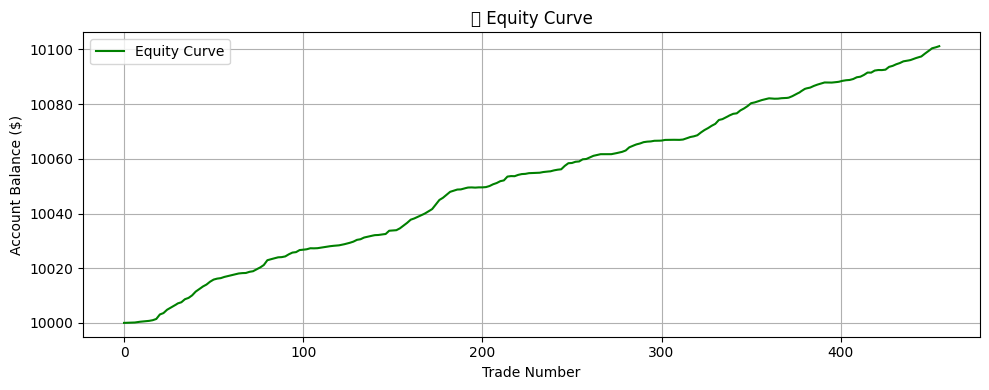

C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1010710186.py:195: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


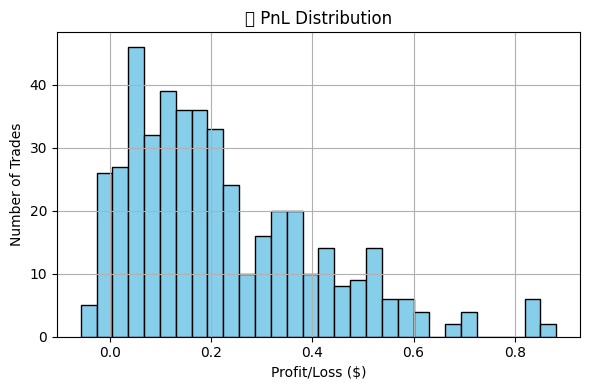

C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1010710186.py:211: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


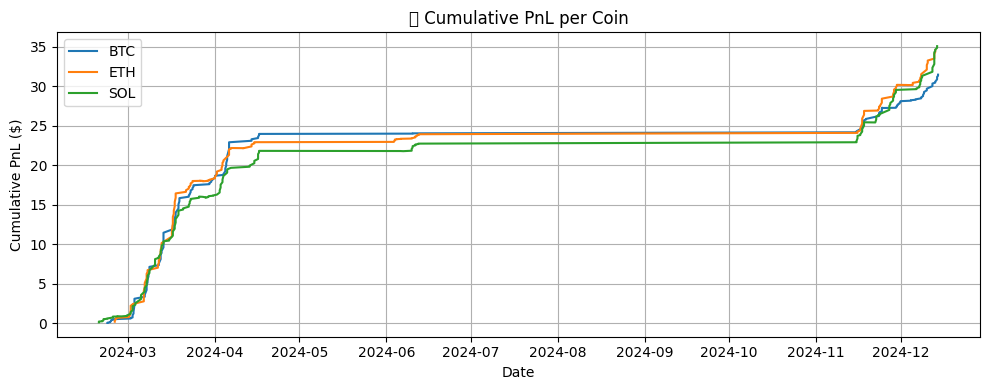

In [15]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN

# === Load datasets ===
btc_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
eth_df = pd.read_csv("dataset/binance_ethusdt_data_2025-03-19.csv")
sol_df = pd.read_csv("dataset/binance_solusdt_data_2025-03-20.csv")

# === Parameters ===
base_funding_rate = 0.000
funding_vol_window = 48
base_trade_size = 0.01
max_trade_size = 0.40
max_open_positions = 10
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
spot_taker_fee = 0.001
futures_taker_fee = 0.0005
funding_interval = 8
base_holding_hours = 120
risk_per_trade_pct = 0.01
trailing_stop_buffer = 0.2

initial_balance = 10000
account_balance = initial_balance
total_profit = 0
open_positions = []
position_id = 0
coin_results = {}
trade_logs = {'BTC': [], 'ETH': [], 'SOL': []}

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(account_balance, entry_price):
    usd_risk = account_balance * risk_per_trade_pct
    raw_size = usd_risk / entry_price
    return round_trade_size(min(raw_size, max_trade_size))

def calculate_funding_and_fees(trade_size, funding_rate, mark_price, entry_spot, entry_futures):
    expected_funding = trade_size * funding_rate * mark_price * (base_holding_hours / funding_interval)
    fees = (
        trade_size * entry_spot * spot_maker_fee +
        trade_size * entry_spot * spot_maker_fee +
        trade_size * entry_futures * futures_maker_fee +
        trade_size * entry_futures * futures_maker_fee
    )
    return expected_funding, fees

def dynamic_threshold(funding_series):
    vol = funding_series.rolling(window=funding_vol_window, min_periods=1).std()
    return base_funding_rate + vol.fillna(0)

# === Main Bot ===
def run_bot(df, symbol):
    global account_balance, total_profit, position_id
    profit_tracker = []

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['dynamic_min_funding'] = dynamic_threshold(df['funding_rate'])

    for i, row in df.iterrows():
        ts = row['timestamp']
        spot = row['close_spot']
        futures = row['close_futures']
        funding = row['funding_rate']
        min_funding = row['dynamic_min_funding']

        # === Close Logic ===
        for pos in open_positions[:]:
            if ts >= pos['target_close_time']:
                size = pos['size']
                entry_ts = pos['entry_time']
                hours_held = (ts - entry_ts).total_seconds() / 3600
                funding_pnl = size * pos['funding_rate'] * pos['mark_price'] * (hours_held / funding_interval)
                spot_pnl = size * (spot - pos['spot']) if pos['funding_rate'] > 0 else size * (pos['spot'] - spot)
                fut_pnl = size * (pos['futures'] - futures) if pos['funding_rate'] > 0 else size * (futures - pos['futures'])
                fee = (
                    size * pos['spot'] * spot_maker_fee + size * spot * spot_maker_fee +
                    size * pos['futures'] * futures_maker_fee + size * futures * futures_maker_fee
                )
                pnl = funding_pnl + spot_pnl + fut_pnl - fee
                account_balance += pnl
                total_profit += pnl
                open_positions.remove(pos)
                profit_tracker.append(pnl)

                trade_logs[symbol].append({
                    'coin': symbol,
                    'trade_size': size,
                    'entry_time': entry_ts,
                    'exit_time': ts,
                    'entry_spot': pos['spot'],
                    'exit_spot': spot,
                    'entry_futures': pos['futures'],
                    'exit_futures': futures,
                    'funding_rate': pos['funding_rate'],
                    'funding_profit': funding_pnl,
                    'fees': fee,
                    'total_pnl': pnl,
                    'hours_held': round(hours_held, 2)
                })

        # === Open Logic ===
        if abs(funding) >= min_funding and len(open_positions) < max_open_positions:
            size = calculate_position_size(account_balance, futures)
            required_margin = size * futures
            max_margin_allowed = account_balance * 0.9

            if required_margin <= max_margin_allowed:
                exp_funding, est_fees = calculate_funding_and_fees(size, funding, futures, spot, futures)
                if exp_funding > est_fees:
                    open_positions.append({
                        'id': position_id,
                        'entry_time': ts,
                        'target_close_time': ts + pd.Timedelta(hours=base_holding_hours),
                        'spot': spot,
                        'futures': futures,
                        'funding_rate': funding,
                        'size': size,
                        'mark_price': futures,
                        'symbol': symbol,
                        'max_pnl': 0
                    })
                    position_id += 1
    return profit_tracker

# === Run Bot ===
datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
all_pnls = []

for sym, df in datasets.items():
    print(f"\n🚀 Running for {sym}...")
    pnl_list = run_bot(df.copy(), sym)
    open_positions.clear()  # prevent carry-over between coins
    coin_results[sym] = {
        'trades': len(pnl_list),
        'win_rate': sum(p > 0 for p in pnl_list) / len(pnl_list) if pnl_list else 0,
        'avg_profit': np.mean(pnl_list) if pnl_list else 0,
        'total_profit': sum(pnl_list)
    }
    all_pnls.extend(pnl_list)
    pd.DataFrame(trade_logs[sym]).to_csv(f"{sym.lower()}_trade_log.csv", index=False)

# === Summary ===
print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls)/len(all_pnls)*100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

print("\n=== COIN-BY-COIN PERFORMANCE ===")
for sym, stats in coin_results.items():
    print(f"{sym}: Trades={stats['trades']}, Win Rate={stats['win_rate']:.2%}, Avg Profit=${stats['avg_profit']:.2f}, Total Profit=${stats['total_profit']:.2f}")

# === Metrics ===
trade_df = pd.DataFrame(all_pnls, columns=["pnl"])
sharpe = trade_df["pnl"].mean() / trade_df["pnl"].std() if trade_df["pnl"].std() > 0 else 0
gross_profit = sum(p for p in all_pnls if p > 0)
gross_loss = abs(sum(p for p in all_pnls if p < 0))
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

print(f"\nSharpe Ratio: {sharpe:.2f}") # for every unit of risk, how much return is made
print(f"Profit Factor: {profit_factor:.2f}") # for every dollar lost, how much profit is made

import matplotlib.pyplot as plt

# === Equity Curve ===
equity_curve = [initial_balance]
for pnl in all_pnls:
    equity_curve.append(equity_curve[-1] + pnl)

plt.figure(figsize=(10, 4))
plt.plot(equity_curve, label='Equity Curve', color='green')
plt.title("📈 Equity Curve")
plt.xlabel("Trade Number")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === PnL Distribution Histogram ===
plt.figure(figsize=(6, 4))
plt.hist(all_pnls, bins=30, color='skyblue', edgecolor='black')
plt.title("💰 PnL Distribution")
plt.xlabel("Profit/Loss ($)")
plt.ylabel("Number of Trades")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Cumulative PnL per Coin ===
plt.figure(figsize=(10, 4))
for coin in trade_logs:
    df = pd.DataFrame(trade_logs[coin])
    if not df.empty:
        df['cumulative_pnl'] = df['total_pnl'].cumsum()
        plt.plot(df['exit_time'], df['cumulative_pnl'], label=coin)

plt.title("📊 Cumulative PnL per Coin")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




🚀 Running for BTC...

🚀 Running for ETH...

🚀 Running for SOL...

=== FINAL SUMMARY ===
Initial Balance: $10000.00
Final Balance:   $10073.99
Total Profit:    $73.99
Total Trades:    555
Win Rate:        77.84%
Avg Profit/Trade:$0.13

=== COIN-BY-COIN PERFORMANCE ===
BTC: Trades=168, Win Rate=79.76%, Avg Profit=$0.12, Total Profit=$20.59
ETH: Trades=170, Win Rate=87.06%, Avg Profit=$0.17, Total Profit=$29.43
SOL: Trades=217, Win Rate=69.12%, Avg Profit=$0.11, Total Profit=$23.98

Sharpe Ratio: 0.52
Profit Factor: 3.65


C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1326652748.py:190: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1326652748.py:190: UserWarning: Glyph 56520 (\udcc8) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 56520 (\udcc8) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


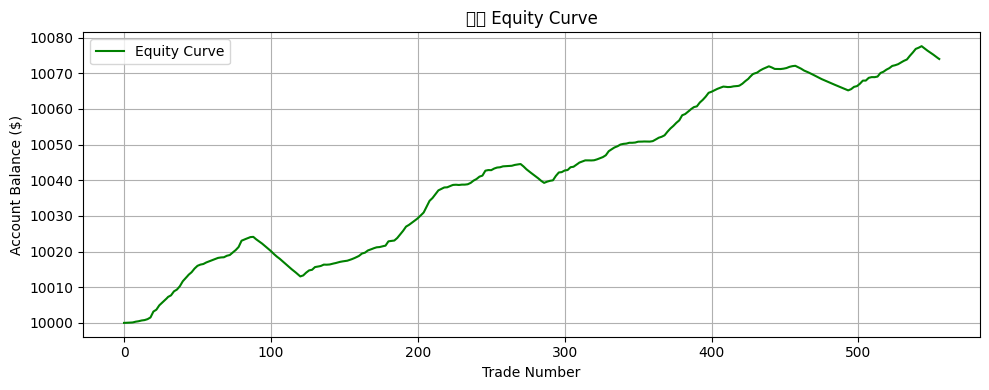

C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1326652748.py:199: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1326652748.py:199: UserWarning: Glyph 56496 (\udcb0) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 56496 (\udcb0) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


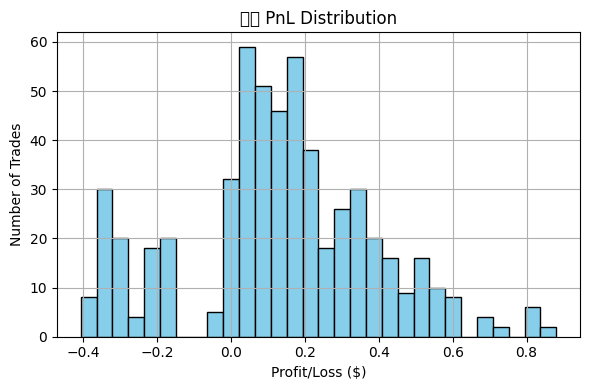

C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1326652748.py:214: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1326652748.py:214: UserWarning: Glyph 56522 (\udcca) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 56522 (\udcca) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


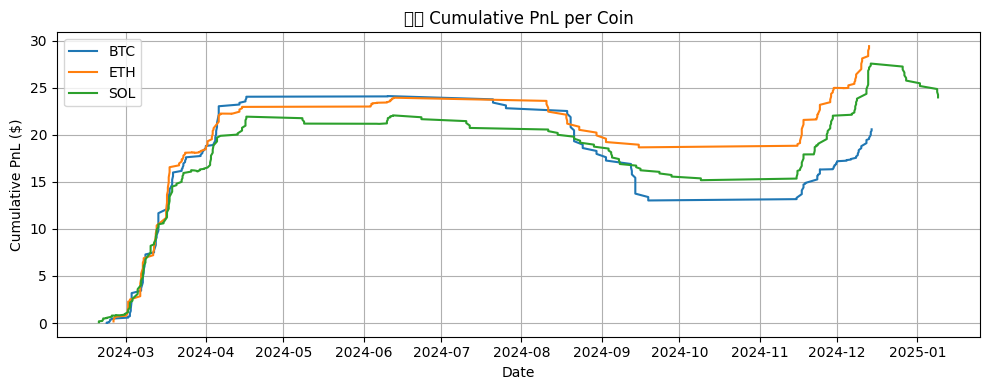

In [27]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN
import matplotlib.pyplot as plt

# === Load datasets ===
btc_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
eth_df = pd.read_csv("dataset/binance_ethusdt_data_2025-03-19.csv")
sol_df = pd.read_csv("dataset/binance_solusdt_data_2025-03-20.csv")

# === Ensure funding_rate is float ===
for df in [btc_df, eth_df, sol_df]:
    df['funding_rate'] = pd.to_numeric(df['funding_rate'], errors='coerce')

# === Parameters ===
base_funding_rate = 0.000
funding_vol_window = 48
base_trade_size = 0.01
max_trade_size = 0.40
max_open_positions = 10
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
funding_interval = 8
base_holding_hours = 120
risk_per_trade_pct = 0.01
initial_balance = 10000

account_balance = initial_balance
total_profit = 0
open_positions = []
position_id = 0
coin_results = {}
trade_logs = {'BTC': [], 'ETH': [], 'SOL': []}

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(account_balance, entry_price):
    usd_risk = account_balance * risk_per_trade_pct
    raw_size = usd_risk / entry_price
    return round_trade_size(min(raw_size, max_trade_size))

def calculate_funding_and_fees(trade_size, funding_rate, mark_price, entry_spot, entry_futures):
    expected_funding = trade_size * funding_rate * mark_price * (base_holding_hours / funding_interval)
    fees = (
        trade_size * entry_spot * spot_maker_fee * 2 +
        trade_size * entry_futures * futures_maker_fee * 2
    )
    return expected_funding, fees

def dynamic_threshold(funding_series):
    vol = funding_series.rolling(window=funding_vol_window, min_periods=1).std()
    return base_funding_rate + vol.fillna(0)

# === Main Bot ===
def run_bot(df, symbol):
    global account_balance, total_profit, position_id
    profit_tracker = []

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['dynamic_min_funding'] = dynamic_threshold(df['funding_rate'])

    for i, row in df.iterrows():
        ts = row['timestamp']
        spot = row['close_spot']
        futures = row['close_futures']
        funding = row['funding_rate']
        min_funding = row['dynamic_min_funding']

        for pos in open_positions[:]:
            if ts >= pos['target_close_time']:
                size = pos['size']
                entry_ts = pos['entry_time']
                hours_held = (ts - entry_ts).total_seconds() / 3600
                funding_pnl = size * pos['funding_rate'] * pos['mark_price'] * (hours_held / funding_interval)

                if pos['direction'] == 'positive':
                    spot_pnl = size * (spot - pos['spot'])
                    fut_pnl = size * (pos['futures'] - futures)
                else:
                    spot_pnl = size * (pos['spot'] - spot)
                    fut_pnl = size * (futures - pos['futures'])

                fee = (
                    size * pos['spot'] * spot_maker_fee * 2 +
                    size * futures * futures_maker_fee * 2
                )

                pnl = funding_pnl + spot_pnl + fut_pnl - fee
                account_balance += pnl
                total_profit += pnl
                open_positions.remove(pos)
                profit_tracker.append(pnl)

                trade_logs[symbol].append({
                    'coin': symbol,
                    'trade_size': size,
                    'entry_time': entry_ts,
                    'exit_time': ts,
                    'entry_spot': pos['spot'],
                    'exit_spot': spot,
                    'entry_futures': pos['futures'],
                    'exit_futures': futures,
                    'funding_rate': pos['funding_rate'],
                    'funding_profit': funding_pnl,
                    'fees': fee,
                    'total_pnl': pnl,
                    'hours_held': round(hours_held, 2),
                    'direction': pos['direction']
                })

        if abs(funding) >= min_funding and len(open_positions) < max_open_positions:
            size = calculate_position_size(account_balance, futures)
            required_margin = size * futures
            max_margin_allowed = account_balance * 0.9

            if required_margin <= max_margin_allowed:
                exp_funding, est_fees = calculate_funding_and_fees(size, funding, futures, spot, futures)
                if (funding > 0 and exp_funding > est_fees) or (funding < 0 and abs(exp_funding) < est_fees):
                    open_positions.append({
                        'id': position_id,
                        'entry_time': ts,
                        'target_close_time': ts + pd.Timedelta(hours=base_holding_hours),
                        'spot': spot,
                        'futures': futures,
                        'funding_rate': funding,
                        'size': size,
                        'mark_price': futures,
                        'symbol': symbol,
                        'max_pnl': 0,
                        'direction': 'positive' if funding > 0 else 'negative'
                    })
                    position_id += 1
    return profit_tracker

# === Run Bot ===
datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
all_pnls = []

for sym, df in datasets.items():
    print(f"\n🚀 Running for {sym}...")
    pnl_list = run_bot(df.copy(), sym)
    open_positions.clear()
    coin_results[sym] = {
        'trades': len(pnl_list),
        'win_rate': sum(p > 0 for p in pnl_list) / len(pnl_list) if pnl_list else 0,
        'avg_profit': np.mean(pnl_list) if pnl_list else 0,
        'total_profit': sum(pnl_list)
    }
    all_pnls.extend(pnl_list)
    pd.DataFrame(trade_logs[sym]).to_csv(f"{sym.lower()}_trade_log.csv", index=False)

# === Summary ===
print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls)/len(all_pnls)*100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

print("\n=== COIN-BY-COIN PERFORMANCE ===")
for sym, stats in coin_results.items():
    print(f"{sym}: Trades={stats['trades']}, Win Rate={stats['win_rate']:.2%}, Avg Profit=${stats['avg_profit']:.2f}, Total Profit=${stats['total_profit']:.2f}")

# === Metrics ===
trade_df = pd.DataFrame(all_pnls, columns=["pnl"])
sharpe = trade_df["pnl"].mean() / trade_df["pnl"].std() if trade_df["pnl"].std() > 0 else 0
gross_profit = sum(p for p in all_pnls if p > 0)
gross_loss = abs(sum(p for p in all_pnls if p < 0))
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

print(f"\nSharpe Ratio: {sharpe:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")

# === Charts ===
equity_curve = [initial_balance]
for pnl in all_pnls:
    equity_curve.append(equity_curve[-1] + pnl)

plt.figure(figsize=(10, 4))
plt.plot(equity_curve, label='Equity Curve', color='green')
plt.title("\ud83d\udcc8 Equity Curve")
plt.xlabel("Trade Number")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(all_pnls, bins=30, color='skyblue', edgecolor='black')
plt.title("\ud83d\udcb0 PnL Distribution")
plt.xlabel("Profit/Loss ($)")
plt.ylabel("Number of Trades")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for coin in trade_logs:
    df = pd.DataFrame(trade_logs[coin])
    if not df.empty:
        df['cumulative_pnl'] = df['total_pnl'].cumsum()
        plt.plot(df['exit_time'], df['cumulative_pnl'], label=coin)

plt.title("\ud83d\udcca Cumulative PnL per Coin")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



🚀 Running for BTC...

🚀 Running for ETH...

🚀 Running for SOL...

=== FINAL SUMMARY ===
Initial Balance: $10000.00
Final Balance:   $10100.85
Total Profit:    $100.85
Total Trades:    457
Win Rate:        94.53%
Avg Profit/Trade:$0.22

=== COIN-BY-COIN PERFORMANCE ===
BTC: Trades=136, Win Rate=98.53%, Avg Profit=$0.23, Total Profit=$31.68
ETH: Trades=154, Win Rate=96.10%, Avg Profit=$0.23, Total Profit=$34.75
SOL: Trades=167, Win Rate=89.82%, Avg Profit=$0.21, Total Profit=$34.41

Sharpe Ratio: 1.15
Profit Factor: 88.04


C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1701143939.py:194: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1701143939.py:194: UserWarning: Glyph 56520 (\udcc8) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 56520 (\udcc8) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


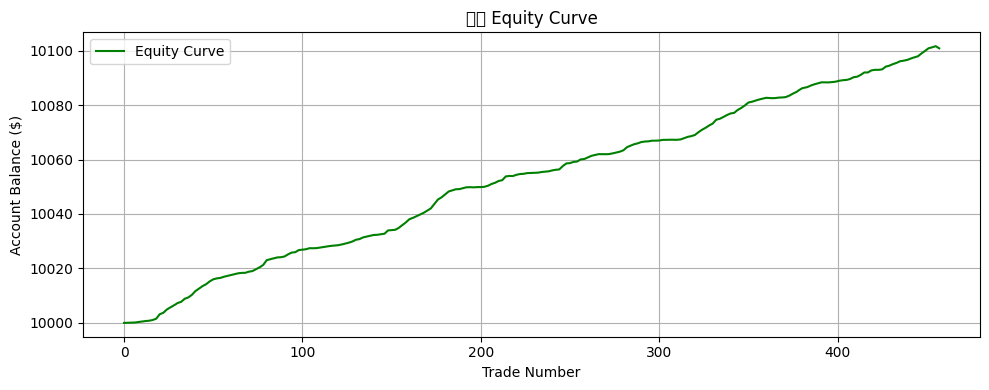

C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1701143939.py:203: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1701143939.py:203: UserWarning: Glyph 56496 (\udcb0) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 56496 (\udcb0) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


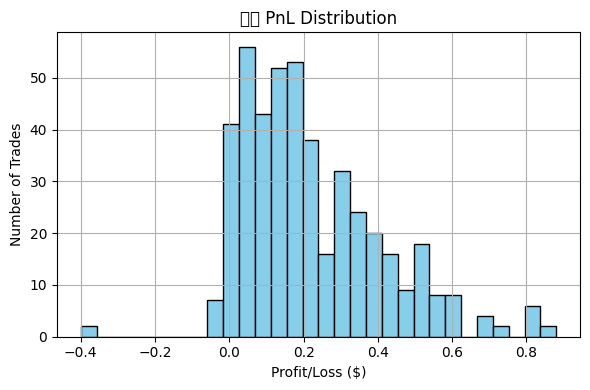

C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1701143939.py:218: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Local\Temp\ipykernel_59904\1701143939.py:218: UserWarning: Glyph 56522 (\udcca) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 55357 (\ud83d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thund\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 56522 (\udcca) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


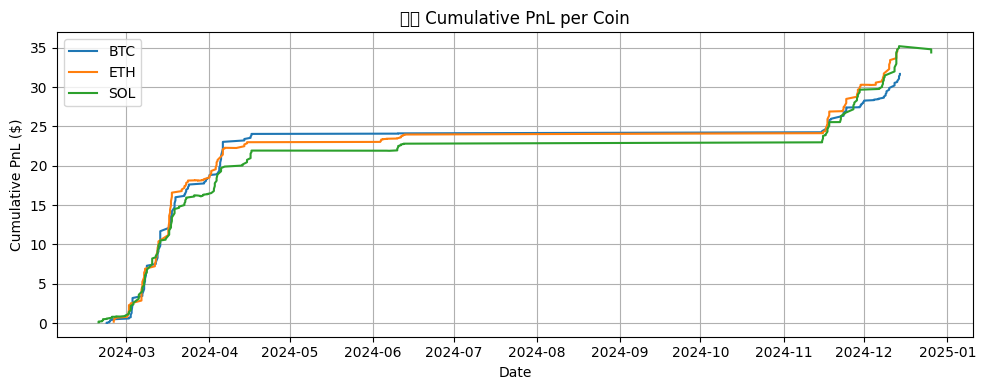

In [30]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN
import matplotlib.pyplot as plt

# === Load datasets ===
btc_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
eth_df = pd.read_csv("dataset/binance_ethusdt_data_2025-03-19.csv")
sol_df = pd.read_csv("dataset/binance_solusdt_data_2025-03-20.csv")

# === Ensure funding_rate is float ===
for df in [btc_df, eth_df, sol_df]:
    df['funding_rate'] = pd.to_numeric(df['funding_rate'], errors='coerce')

# === Parameters ===
base_funding_rate = 0.000
funding_vol_window = 48
base_trade_size = 0.01
max_trade_size = 0.40
max_open_positions = 10
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
funding_interval = 8
base_holding_hours = 120
risk_per_trade_pct = 0.01
initial_balance = 10000

account_balance = initial_balance
total_profit = 0
open_positions = []
position_id = 0
coin_results = {}
trade_logs = {'BTC': [], 'ETH': [], 'SOL': []}

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(account_balance, entry_price):
    usd_risk = account_balance * risk_per_trade_pct
    raw_size = usd_risk / entry_price
    return round_trade_size(min(raw_size, max_trade_size))

def calculate_funding_and_fees(trade_size, funding_rate, mark_price, entry_spot, entry_futures):
    expected_funding = trade_size * funding_rate * mark_price * (base_holding_hours / funding_interval)
    fees = (
        trade_size * entry_spot * spot_maker_fee * 2 +
        trade_size * entry_futures * futures_maker_fee * 2
    )
    return expected_funding, fees

def dynamic_threshold(funding_series):
    vol = funding_series.rolling(window=funding_vol_window, min_periods=1).std()
    return base_funding_rate + vol.fillna(0)

# === Main Bot ===
def run_bot(df, symbol):
    global account_balance, total_profit, position_id
    profit_tracker = []

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['dynamic_min_funding'] = dynamic_threshold(df['funding_rate'])

    for i, row in df.iterrows():
        ts = row['timestamp']
        spot = row['close_spot']
        futures = row['close_futures']
        funding = row['funding_rate']
        min_funding = row['dynamic_min_funding']

        # Close existing positions
        for pos in open_positions[:]:
            if ts >= pos['target_close_time']:
                size = pos['size']
                entry_ts = pos['entry_time']
                hours_held = (ts - entry_ts).total_seconds() / 3600
                funding_pnl = size * pos['funding_rate'] * pos['mark_price'] * (hours_held / funding_interval)

                if pos['direction'] == 'positive':
                    spot_pnl = size * (spot - pos['spot'])
                    fut_pnl = size * (pos['futures'] - futures)
                else:
                    spot_pnl = size * (pos['spot'] - spot)
                    fut_pnl = size * (futures - pos['futures'])

                fee = (
                    size * pos['spot'] * spot_maker_fee * 2 +
                    size * futures * futures_maker_fee * 2
                )

                pnl = funding_pnl + spot_pnl + fut_pnl - fee
                account_balance += pnl
                total_profit += pnl
                open_positions.remove(pos)
                profit_tracker.append(pnl)

                trade_logs[symbol].append({
                    'coin': symbol,
                    'trade_size': size,
                    'entry_time': entry_ts,
                    'exit_time': ts,
                    'entry_spot': pos['spot'],
                    'exit_spot': spot,
                    'entry_futures': pos['futures'],
                    'exit_futures': futures,
                    'funding_rate': pos['funding_rate'],
                    'funding_profit': funding_pnl,
                    'fees': fee,
                    'total_pnl': pnl,
                    'hours_held': round(hours_held, 2),
                    'direction': pos['direction']
                })

        # Open new positions with improved logic
        if abs(funding) >= min_funding and len(open_positions) < max_open_positions:
            size = calculate_position_size(account_balance, futures)
            required_margin = size * futures
            max_margin_allowed = account_balance * 0.9

            if required_margin <= max_margin_allowed:
                exp_funding, est_fees = calculate_funding_and_fees(size, funding, futures, spot, futures)
                
                # Improved trade entry condition for both positive and negative funding rates
                if (funding > 0 and exp_funding > est_fees) or (funding < 0 and abs(exp_funding) > est_fees):
                    open_positions.append({
                        'id': position_id,
                        'entry_time': ts,
                        'target_close_time': ts + pd.Timedelta(hours=base_holding_hours),
                        'spot': spot,
                        'futures': futures,
                        'funding_rate': funding,
                        'size': size,
                        'mark_price': futures,
                        'symbol': symbol,
                        'max_pnl': 0,
                        'direction': 'positive' if funding > 0 else 'negative'
                    })
                    position_id += 1
    return profit_tracker

# === Run Bot ===
datasets = {"BTC": btc_df, "ETH": eth_df, "SOL": sol_df}
all_pnls = []

for sym, df in datasets.items():
    print(f"\n🚀 Running for {sym}...")
    pnl_list = run_bot(df.copy(), sym)
    open_positions.clear()
    coin_results[sym] = {
        'trades': len(pnl_list),
        'win_rate': sum(p > 0 for p in pnl_list) / len(pnl_list) if pnl_list else 0,
        'avg_profit': np.mean(pnl_list) if pnl_list else 0,
        'total_profit': sum(pnl_list)
    }
    all_pnls.extend(pnl_list)
    pd.DataFrame(trade_logs[sym]).to_csv(f"{sym.lower()}_trade_log.csv", index=False)

# === Summary ===
print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls)/len(all_pnls)*100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

print("\n=== COIN-BY-COIN PERFORMANCE ===")
for sym, stats in coin_results.items():
    print(f"{sym}: Trades={stats['trades']}, Win Rate={stats['win_rate']:.2%}, Avg Profit=${stats['avg_profit']:.2f}, Total Profit=${stats['total_profit']:.2f}")

# === Metrics ===
trade_df = pd.DataFrame(all_pnls, columns=["pnl"])
sharpe = trade_df["pnl"].mean() / trade_df["pnl"].std() if trade_df["pnl"].std() > 0 else 0
gross_profit = sum(p for p in all_pnls if p > 0)
gross_loss = abs(sum(p for p in all_pnls if p < 0))
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

print(f"\nSharpe Ratio: {sharpe:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")

# === Charts ===
equity_curve = [initial_balance]
for pnl in all_pnls:
    equity_curve.append(equity_curve[-1] + pnl)

plt.figure(figsize=(10, 4))
plt.plot(equity_curve, label='Equity Curve', color='green')
plt.title("\ud83d\udcc8 Equity Curve")
plt.xlabel("Trade Number")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(all_pnls, bins=30, color='skyblue', edgecolor='black')
plt.title("\ud83d\udcb0 PnL Distribution")
plt.xlabel("Profit/Loss ($)")
plt.ylabel("Number of Trades")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for coin in trade_logs:
    df = pd.DataFrame(trade_logs[coin])
    if not df.empty:
        df['cumulative_pnl'] = df['total_pnl'].cumsum()
        plt.plot(df['exit_time'], df['cumulative_pnl'], label=coin)

plt.title("\ud83d\udcca Cumulative PnL per Coin")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()